### Future considerations for improvement:
- Look into Home/Away data
- Refine offensive/defensive characterization
- Explore boosted models
- Explore neural nets
- Get Class/Height/Weight of Players, then generate a "mismatch" feature

## Imports

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

import os
import re
from datetime import datetime
from datetime import timedelta
from operator import itemgetter
from string import digits

import time

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Read in Player-By-Player Data from Scraper

In [2]:
df = pd.read_csv('../data/player_boxscores_df.csv', index_col=0)
df['date_game'] = pd.to_datetime(df['date_game'])
df.set_index(['player', 'date_game'], drop=False, inplace=True)
df.head()

,,player,pos,date_game,school_id,opp_id,gs,mp,fg,fga,fg2,...,stl,blk,tov,pf,pts,game_score,year,month,season,W
player,date_game,,,,,,,,,,,,,,,,,,,,,
Nate Wolters,2013-02-07,Nate Wolters,G,2013-02-07,South Dakota State,IPFW,1.0,40,17,28,8,...,1,1,3,0,53,42.6,2013,2,2013,1
Marshon Brooks,2011-02-23,Marshon Brooks,G,2011-02-23,Providence,Notre Dame,1.0,40,20,28,14,...,1,0,1,4,52,42.3,2011,2,2011,0
Jimmer Fredette,2011-03-11,Jimmer Fredette,G,2011-03-11,Brigham Young,New Mexico,1.0,40,22,37,15,...,1,0,2,2,52,36.5,2011,3,2011,1
Markus Howard,2018-01-03,Markus Howard,G,2018-01-03,Marquette,Providence,1.0,44,17,29,6,...,2,0,2,1,52,39.8,2018,1,2018,1
Mike Daum,2017-02-18,Mike Daum,F,2017-02-18,South Dakota State,IPFW,1.0,36,14,29,7,...,0,1,2,0,51,39.8,2017,2,2017,1


In [3]:
df.duplicated().sum()

0

In [4]:
df.shape

(870131, 28)

In [6]:
# Data spans 2011 through 2018 seasons
print(df['date_game'].max())
print(df['date_game'].min())

2018-03-07 00:00:00
2010-11-08 00:00:00


In [7]:
# 345 Schools in 2011
len(df[df['season']==2011]['school_id'].unique())

345

In [8]:
# 351 Schools in 2018
len(df[df['year']==2018]['school_id'].unique())

351

## Bring in School Data from Scraper

In [9]:
school_df = pd.read_csv('../data/schools.csv', index_col=0)
school_df.head()

,School,WinLossPct,SRS,SOS,Year
0,Air Force,0.323,-4.90,3.13,2010
1,Akron,0.686,2.82,-1.50,2010
2,Alabama A&M,0.407,-20.19,-13.71,2010
3,Alabama-Birmingham,0.735,9.46,2.90,2010
4,Alabama State,0.516,-14.41,-12.02,2010


In [10]:
school_df = school_df.rename(columns = {'School':'school_id', 'Year':'year'})

In [11]:
school_df.set_index(['school_id', 'year'], drop=False, inplace=True)

In [12]:
school_df.head()

,,school_id,WinLossPct,SRS,SOS,year
school_id,year,,,,,
Air Force,2010,Air Force,0.323,-4.90,3.13,2010
Akron,2010,Akron,0.686,2.82,-1.50,2010
Alabama A&M,2010,Alabama A&M,0.407,-20.19,-13.71,2010
Alabama-Birmingham,2010,Alabama-Birmingham,0.735,9.46,2.90,2010
Alabama State,2010,Alabama State,0.516,-14.41,-12.02,2010


In [45]:
# Explore some of the reoccuring "Winningest" Teams

top10_schools_2010 = school_df[school_df['year']==2010].sort_values('WinLossPct', ascending=False)['school_id'][0:10]
top10_pct_2010 = school_df[school_df['year']==2010].sort_values('WinLossPct', ascending=False)['WinLossPct'][0:10]

top10_schools_2011 = school_df[school_df['year']==2011].sort_values('WinLossPct', ascending=False)['school_id'][0:10]
top10_pct_2011 = school_df[school_df['year']==2011].sort_values('WinLossPct', ascending=False)['WinLossPct'][0:10]

top10_schools_2018 = school_df[school_df['year']==2018].sort_values('WinLossPct', ascending=False)['school_id'][0:10]
top10_pct_2018 = school_df[school_df['year']==2018].sort_values('WinLossPct', ascending=False)['WinLossPct'][0:10]

In [55]:
plotrange = np.arange(0,11)

In [59]:
top10_schools_2010

school_id      year
Kentucky       2010         Kentucky
Kansas         2010           Kansas
Duke           2010             Duke
Butler         2010           Butler
Murray State   2010     Murray State
Syracuse       2010         Syracuse
Northern Iowa  2010    Northern Iowa
New Mexico     2010       New Mexico
Cornell        2010          Cornell
Brigham Young  2010    Brigham Young
Name: school_id, dtype: object

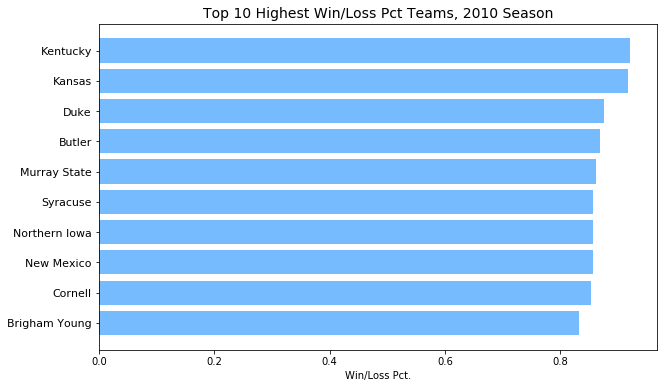

In [93]:
fig, ax = plt.subplots(figsize=(10,6))

plt.barh(plotrange[10:0:-1], top10_pct_2010, color='xkcd:sky blue')
plt.yticks(plotrange[10:0:-1], top10_schools_2010.values)

plt.title('Top 10 Highest Win/Loss Pct Teams, 2010 Season', fontsize=14)
plt.xlabel('Win/Loss Pct.')
plt.yticks(fontsize=11);

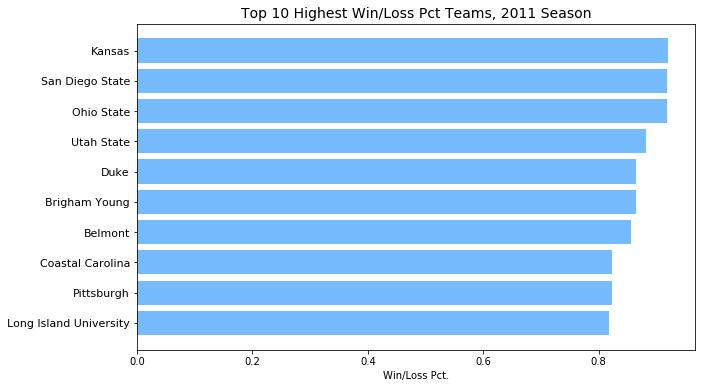

In [92]:
fig, ax = plt.subplots(figsize=(10,6))

plt.barh(plotrange[10:0:-1], top10_pct_2011, color='xkcd:sky blue')
plt.yticks(plotrange[10:0:-1], top10_schools_2011.values)

plt.title('Top 10 Highest Win/Loss Pct Teams, 2011 Season', fontsize=14)
plt.xlabel('Win/Loss Pct.')
plt.yticks(fontsize=11);

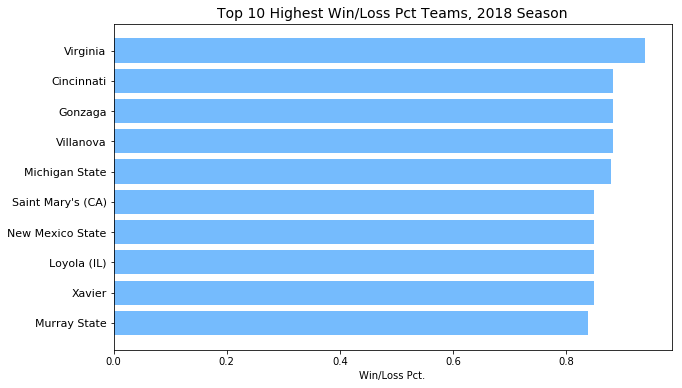

In [91]:
fig, ax = plt.subplots(figsize=(10,6))

plt.barh(plotrange[10:0:-1], top10_pct_2018, color='xkcd:sky blue')
plt.yticks(plotrange[10:0:-1], top10_schools_2018.values)

plt.title('Top 10 Highest Win/Loss Pct Teams, 2018 Season', fontsize=14)
plt.xlabel('Win/Loss Pct.')
plt.yticks(fontsize=11);

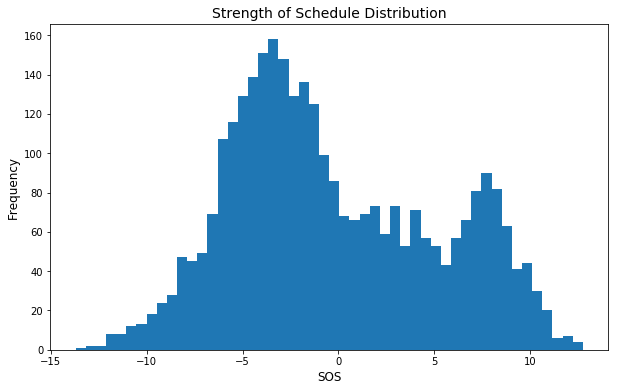

In [88]:
fig, ax = plt.subplots(figsize=(10,6))

plt.hist(school_df['SOS'], bins=50)
plt.title('Strength of Schedule Distribution', fontsize=14)
plt.xlabel('SOS', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

- Looks like there are two peaks here, indicative that some conferences may be tougher than others

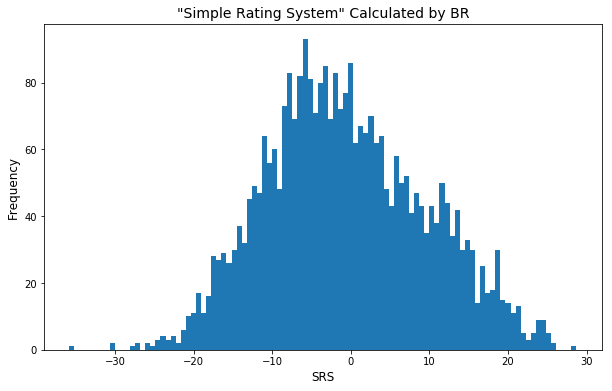

In [90]:
fig, ax = plt.subplots(figsize=(10,6))

plt.hist(school_df['SRS'], bins=100)
plt.title('"Simple Rating System" Calculated by BR', fontsize=14)
plt.xlabel('SRS', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

- Central tendency towards 0, as expected (Negative SRS indicates 'worse' teams, Positive SRS indicates 'better' teams)

# Evaluation at the Team Level

### Set up "MyTeam"

In [94]:
myteam_df = df.groupby(['school_id', 'opp_id', 'date_game']).sum()

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'date_game' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [95]:
# Sum of 'game_started' flag and 'minutes_played' meaningless, so we can drop
myteam_df.drop(['gs', 'mp', 'month', 'year', 'season'], axis=1, inplace=True)

In [96]:
# Drop 'fg' and 'fga' since these are captured in 'fg2'/'fg2a'/'fg3'/'fg3a'
myteam_df.drop(['fg', 'fga'], axis=1, inplace=True)

In [97]:
# Change to 0/1 Flags
myteam_df['W'] = myteam_df['W'].apply(lambda x: 1 if x > 0 else 0)

In [98]:
myteam_df.reset_index(inplace=True)

In [99]:
myteam_df.set_index(['school_id', 'date_game'], drop=False, inplace=True)

In [100]:
myteam_df.head()

school_id               opp_id  \
school_id         date_game                                            
Abilene Christian 2017-12-06  Abilene Christian            Air Force   
                  2017-11-13  Abilene Christian       Arkansas State   
                  2014-12-23  Abilene Christian  Arkansas-Pine Bluff   
                  2014-12-20  Abilene Christian          Boise State   
                  2017-11-26  Abilene Christian  Bowling Green State   

                              date_game  fg2  fg2a  fg3  fg3a  ft  fta  orb  \
school_id         date_game                                                   
Abilene Christian 2017-12-06 2017-12-06   14    29    9    25   7   15    7   
                  2017-11-13 2017-11-13   22    32    3    13  16   20    5   
                  2014-12-23 2014-12-23   14    25   10    20  11   16    5   
                  2014-12-20 2014-12-20    5    36    6    19   5    6   11   
                  2017-11-26 2017-11-26   28    48    6    16  14   18   10   

                              drb  ast  stl  blk  tov  pf  pts  game_score  W  
school_id         date_game                                                    
Abilene Christian 2017-12-06   17   11    8    4   12  16   62        40.3  1  
                  2017-11-13   14   11    4    2   13  19   69        46.1  0  
                  2014-12-23   22   15    7    2   18  21   69        47.7  1  
                  2014-12-20   10    4    4    0    9  12   33         2.2  0  
                  2017-11-26   26   18    2    6    8  18   88        73.6  1

In [123]:
win_indices = ['2010-11-12', '2010-11-14', '2010-11-23', '2010-11-30', '2010-12-18',
              '2010-12-22', '2010-12-29', '2010-12-31', '2011-01-02', '2011-01-08',
              '2011-01-13', '2011-01-15', '2011-01-29', '2011-02-03', '2011-02-10',
              '2011-02-12', '2011-02-17', '2011-02-19', '2011-02-24', '2011-02-26',
              '2011-02-28']

win_indices = pd.to_datetime(win_indices)

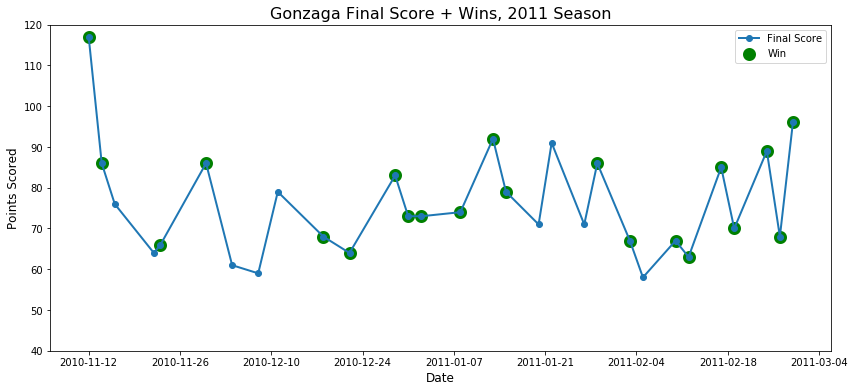

In [151]:
fig, ax = plt.subplots(figsize=(14,6))

plt.plot(myteam_df.loc['Gonzaga'].sort_values('date_game')['pts'][0:30], linewidth=2, 
         marker='o', label='Final Score')
plt.scatter(win_indices, myteam_df.loc['Gonzaga'].loc[win_indices]['pts'], linewidth=7, 
            color='g', label='Win')

plt.title('Gonzaga Final Score + Wins, 2011 Season', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Points Scored', fontsize=12)
plt.ylim(40,120)
plt.legend()

- Note that higher scores don't always gaurantee wins, and lower scores don't always gaurantee losses

### Set up "YourTeam" (which I will be base defensive characteristics on)

In [ ]:
yourteam_df = df.groupby(['opp_id', 'school_id', 'date_game']).sum()

# Sum of 'game_started' flag and 'minutes_played' meaningless, so we can drop
yourteam_df.drop(['gs', 'mp', 'year', 'month', 'season'], axis=1, inplace=True)

# Drop 'fg' and 'fga' since these are captured in 'fg2'/'fg2a'/'fg3'/'fg3a'
yourteam_df.drop(['fg', 'fga'], axis=1, inplace=True)

# Change to 0/1 Flags
yourteam_df['W'] = yourteam_df['W'].apply(lambda x: 1 if x > 0 else 0)

yourteam_df.reset_index(inplace=True)

yourteam_df.set_index(['opp_id', 'date_game'], drop=False, inplace=True)

In [ ]:
yourteam_df.columns = 'heldto_' + yourteam_df.columns

In [ ]:
yourteam_df.head()

### "MyTeam" Rolling/EWM Statistics Generation

In [19]:
myteam_stats = ['date_game', 'opp_id', 'fg2', 'fg2a', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 
         'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'game_score', 'W']

In [ ]:
teams = df['school_id'].unique()

In [ ]:
len(teams)

In [ ]:
# Stack a cross-section of rolling stats horizontally, then output to csv file for each team
for team in teams:
    one_team_df = myteam_df.loc[team][myteam_stats].sort_values('date_game')
    
    ewm_03 = one_team_df.drop(['date_game', 'opp_id'], axis=1).ewm(span=3).mean().shift()
    ewm_10 = one_team_df.drop(['date_game', 'opp_id'], axis=1).ewm(span=10).mean().shift()
    ewm_20 = one_team_df.drop(['date_game', 'opp_id'], axis=1).ewm(span=20).mean().shift()
    rm_30 = one_team_df.drop(['date_game', 'opp_id'], axis=1).rolling(window=30).mean().shift()

    this_df = pd.concat([ewm_03, ewm_10, ewm_20, rm_30], axis=1)
    
    this_df['school_id'] = team
    this_df['date_game'] = one_team_df['date_game']
    this_df['opp_id'] = one_team_df['opp_id']

    this_df.to_csv('../data/myteam_ewm/'+team.replace(' ', '_')+'.csv')

In [ ]:
# Read in csv files, and stack vertically, then output to final csv file
for (dirpath, dirnames, filenames) in os.walk('../data/myteam_ewm/'):
    break

f = filenames # [:3] for testing

with open('../data/myteam_ewm_df.csv', 'wb') as output:
    for filename in f:
        with open('../data/myteam_ewm/'+filename, 'rb') as _input:
            for i, line in enumerate(_input):
                if i == 0:
                    continue       
                #print(line) # for testing
                output.write(line)

In [14]:
# Read in final rolling stats df
myteam_ewm_df = pd.read_csv('../data/myteam_ewm_df.csv', header=None)

In [15]:
myteam_ewm_df.shape

(87171, 68)

In [16]:
# Drop duplicate of opposing team
myteam_ewm_df.drop(66, axis=1, inplace=True)

In [17]:
myteam_ewm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,67
0,2010-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Old Dominion
1,2010-11-23,8.000000,32.000000,8.000000,22.000000,17.000000,29.000000,10.000000,19.000000,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Citadel
2,2010-11-28,14.666667,42.000000,4.000000,12.000000,19.666667,31.666667,10.000000,20.333333,7.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Hampton
3,2010-12-02,13.714286,39.142857,5.142857,12.000000,19.857143,27.857143,7.142857,23.571429,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Gardner-Webb
4,2010-12-04,16.533333,39.066667,4.000000,10.933333,19.400000,28.466667,6.533333,22.733333,9.466667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,North Carolina-Asheville


In [20]:
myteam_stats = pd.Series(myteam_stats)

In [21]:
myteam_cols = []
for i in ['ewm03', 'ewm10', 'ewm20', 'rm30']:
    for j in myteam_stats.drop([0,1]):
        myteam_cols.append(i+j)

In [22]:
myteam_cols.insert(0, 'date_game')
myteam_cols.append('school_id')
myteam_cols.append('opp_id')

In [23]:
myteam_ewm_df.columns = myteam_cols

In [24]:
myteam_ewm_df.head()

,date_game,ewm03fg2,ewm03fg2a,ewm03fg3,ewm03fg3a,ewm03ft,ewm03fta,ewm03orb,ewm03drb,ewm03ast,...,rm30ast,rm30stl,rm30blk,rm30tov,rm30pf,rm30pts,rm30game_score,rm30W,school_id,opp_id
0,2010-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Old Dominion
1,2010-11-23,8.000000,32.000000,8.000000,22.000000,17.000000,29.000000,10.000000,19.000000,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Citadel
2,2010-11-28,14.666667,42.000000,4.000000,12.000000,19.666667,31.666667,10.000000,20.333333,7.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Hampton
3,2010-12-02,13.714286,39.142857,5.142857,12.000000,19.857143,27.857143,7.142857,23.571429,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Gardner-Webb
4,2010-12-04,16.533333,39.066667,4.000000,10.933333,19.400000,28.466667,6.533333,22.733333,9.466667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,North Carolina-Asheville


In [25]:
myteam_ewm_df['date_game'] = pd.to_datetime(myteam_ewm_df['date_game'])

### "YourTeam" Rolling/EWM Statistics Generation

In [26]:
yourteam_stats = ['heldto_school_id', 'heldto_date_game', 'heldto_fg2',
       'heldto_fg2a', 'heldto_fg3', 'heldto_fg3a', 'heldto_ft', 'heldto_fta',
       'heldto_orb', 'heldto_drb', 'heldto_ast', 'heldto_stl', 'heldto_blk',
       'heldto_tov', 'heldto_pf', 'heldto_pts', 'heldto_game_score',
       'heldto_W']

In [ ]:
# Stack a cross-section of rolling stats horizontally, then output to csv file for each team
for team in teams:
    try:
        one_team_df = yourteam_df.loc[team][yourteam_stats].sort_values('heldto_date_game')

        ewm_03 = one_team_df.drop(['heldto_date_game', 'heldto_school_id'], axis=1).ewm(span=3).mean().shift()
        ewm_10 = one_team_df.drop(['heldto_date_game', 'heldto_school_id'], axis=1).ewm(span=10).mean().shift()
        ewm_20 = one_team_df.drop(['heldto_date_game', 'heldto_school_id'], axis=1).ewm(span=20).mean().shift()
        rm_30 = one_team_df.drop(['heldto_date_game', 'heldto_school_id'], axis=1).rolling(window=30).mean().shift()

        this_df = pd.concat([ewm_03, ewm_10, ewm_20, rm_30], axis=1)

        this_df['heldto_opp_id'] = team
        this_df['heldto_date_game'] = one_team_df['heldto_date_game']
        this_df['heldto_school_id'] = one_team_df['heldto_school_id']

        this_df.to_csv('../data/yourteam_ewm/'+team.replace(' ', '_')+'.csv')
    except:
        pass

In [ ]:
# Read in csv files, and stack vertically, then output to final csv file
for (dirpath, dirnames, filenames) in os.walk('../data/yourteam_ewm/'):
    break

f = filenames # [:3] for testing

with open('../data/yourteam_ewm_df.csv', 'wb') as output:
    for filename in f:
        with open('../data/yourteam_ewm/'+filename, 'rb') as _input:
            for i, line in enumerate(_input):
                if i == 0:
                    continue       
                #print(line) # for testing
                output.write(line)

In [27]:
# Read in final rolling stats df
yourteam_ewm_df = pd.read_csv('../data/yourteam_ewm_df.csv', header=None)

In [28]:
yourteam_ewm_df.shape

(87171, 68)

In [29]:
# Drop duplicate of opposing team
yourteam_ewm_df.drop(66, axis=1, inplace=True)

In [30]:
yourteam_stats = pd.Series(yourteam_stats)

In [31]:
yourteam_cols = []
for i in ['ewm03', 'ewm10', 'ewm20', 'rm30']:
    for j in yourteam_stats.drop([0,1]):
        yourteam_cols.append(i+j)

In [32]:
yourteam_cols.insert(0, 'date_game')
yourteam_cols.append('heldto_opp_id')
yourteam_cols.append('heldto_school_id')

In [33]:
yourteam_ewm_df.columns = yourteam_cols

In [34]:
yourteam_ewm_df['date_game'] = pd.to_datetime(yourteam_ewm_df['date_game'])

## Join "MyTeam" and "YourTeam"

In [ ]:
temp_my = myteam_ewm_df.set_index(['school_id', 'date_game'], drop=False)

In [ ]:
temp_my.head()

In [ ]:
# Rename these cols so that 'join' will work later
yourteam_ewm_df.rename(columns={'heldto_school_id':'school_id'}, inplace=True)
yourteam_ewm_df.rename(columns={'heldto_opp_id':'opp_id'}, inplace=True)

In [ ]:
temp_your = yourteam_ewm_df.set_index(['school_id', 'date_game'], drop=False)

In [ ]:
temp_your.head()

In [ ]:
joined = temp_my.join(temp_your, how='left', on=['school_id', 'date_game'], rsuffix='_r')

In [ ]:
joined.head()

In [ ]:
joined.shape

In [ ]:
joined.isnull().sum()

In [ ]:
# EWM gave us first day NA's, RM gave us first 30 days NA's
joined.dropna(inplace=True)

In [ ]:
# Bring in the target column, the W's
joined = joined.join(myteam_df['W'], how='left', on=['school_id', 'date_game'])

In [ ]:
# Drop repeat data
joined.drop(['date_game', 'school_id', 'date_game_r', 'opp_id_r', 'school_id_r'], 
            axis=1, inplace=True)

### Add SOS and SRS data

In [ ]:
# A lot of brute force work below, 'join/merge' very finicky with multiple index levels

In [ ]:
joined.head()

In [ ]:
joined.reset_index(drop=False, inplace=True)

In [ ]:
joined['year'] = joined['date_game'].apply(lambda x: x.year)

In [ ]:
joined.set_index(['school_id', 'year'], drop=False, inplace=True)

In [ ]:
joined.head()

In [ ]:
joined = joined.join(school_df[['SRS', 'SOS']], how='left', on=['school_id', 'year'])

In [ ]:
joined.drop(['school_id', 'year'], axis=1, inplace=True)

In [ ]:
joined.reset_index(drop=False, inplace=True)

In [ ]:
joined.set_index(['opp_id', 'year'], drop=False, inplace=True)

In [ ]:
joined.head()

In [ ]:
school_df.drop(['year', 'school_id'], axis=1, inplace=True)

In [ ]:
school_df.reset_index(drop=False, inplace=True)

In [ ]:
school_df = school_df.rename(columns={'school_id':'opp_id', 'SRS':'opp_SRS', 'SOS':'opp_SOS'})

In [ ]:
school_df.set_index(['opp_id', 'year'], drop=False, inplace=True)

In [ ]:
school_df.head()

In [ ]:
joined = joined.join(school_df[['opp_SRS', 'opp_SOS']], how='left', on=['opp_id', 'year'])

In [ ]:
joined.head()

In [ ]:
list(joined.columns)

In [ ]:
joined.drop(['year', 'opp_id'], axis=1, inplace=True)

In [ ]:
joined.reset_index(inplace=True, drop=False)

In [ ]:
joined.drop(['year'], axis=1, inplace=True)

In [ ]:
joined.set_index(['school_id', 'date_game', 'opp_id'], inplace=True)

In [ ]:
joined.head()

In [ ]:
joined.isnull().sum()

In [ ]:
joined.dropna(inplace=True)

In [ ]:
list(joined.dtypes)

### Add Poll Rankings (Abandoned, little improvement, skip over this section)

In [ ]:
# Leave 2018 out for now, structured a little differently
polls_2010 = pd.read_csv('../data/polls_rank/2010_polls.csv', sep='\t', header=None)
polls_2011 = pd.read_csv('../data/polls_rank/2011_polls.csv', sep='\t', header=None)
polls_2012 = pd.read_csv('../data/polls_rank/2012_polls.csv', sep='\t', header=None)
polls_2013 = pd.read_csv('../data/polls_rank/2013_polls.csv', sep='\t', header=None)
polls_2014 = pd.read_csv('../data/polls_rank/2014_polls.csv', sep='\t', header=None)
polls_2015 = pd.read_csv('../data/polls_rank/2015_polls.csv', sep='\t', header=None)
polls_2016 = pd.read_csv('../data/polls_rank/2016_polls.csv', sep='\t', header=None)
polls_2017 = pd.read_csv('../data/polls_rank/2017_polls.csv', sep='\t', header=None)

In [ ]:
polls_2010.replace('Final', '2010-03-15', inplace=True)
polls_2010.replace('Preseason', '2009-11-09', inplace=True)

polls_2011.replace('Final', '2011-03-15', inplace=True)
polls_2011.replace('Preseason', '2010-11-09', inplace=True)

polls_2012.replace('Final', '2012-03-15', inplace=True)
polls_2012.replace('Preseason', '2011-11-09', inplace=True)

polls_2013.replace('Final', '2013-03-15', inplace=True)
polls_2013.replace('Preseason', '2012-11-09', inplace=True)

polls_2014.replace('Final', '2014-03-15', inplace=True)
polls_2014.replace('Preseason', '2013-11-09', inplace=True)

polls_2015.replace('Final', '2015-03-15', inplace=True)
polls_2015.replace('Preseason', '2014-11-09', inplace=True)

polls_2016.replace('Final', '2016-03-15', inplace=True)
polls_2016.replace('Preseason', '2015-11-09', inplace=True)

polls_2017.replace('Final', '2017-03-15', inplace=True)
polls_2017.replace('Preseason', '2016-11-09', inplace=True)

In [ ]:
# AP Polls from 0:492, Coaches Polls from 494: (2010, 2011, 2013, 2014)
# AP Polls from 0:493, Coaches Polls from 495: (2012, 2015, 2016)
# AP Polls from 0:494, Coaches Polls from 496: (2017)
polls_2017.loc[495]

In [ ]:
AP_polls_2010 = polls_2010.loc[:492]
Coach_polls_2010 = polls_2010.loc[494:]

AP_polls_2011 = polls_2011.loc[:492]
Coach_polls_2011 = polls_2011.loc[494:]

AP_polls_2012 = polls_2012.loc[:493]
Coach_polls_2012 = polls_2012.loc[495:]

AP_polls_2013 = polls_2013.loc[:492]
Coach_polls_2013 = polls_2013.loc[494:]

AP_polls_2014 = polls_2014.loc[:492]
Coach_polls_2014 = polls_2014.loc[494:]

AP_polls_2015 = polls_2015.loc[:493]
Coach_polls_2015 = polls_2015.loc[495:]

AP_polls_2016 = polls_2016.loc[:493]
Coach_polls_2016 = polls_2016.loc[495:]

AP_polls_2017 = polls_2017.loc[:494]
Coach_polls_2017 = polls_2017.loc[496:]

In [ ]:
AP_polls = pd.concat([AP_polls_2010, AP_polls_2011, AP_polls_2012, AP_polls_2013, AP_polls_2014,
                      AP_polls_2015, AP_polls_2016, AP_polls_2017])

Coach_polls = pd.concat([Coach_polls_2010, Coach_polls_2011, Coach_polls_2012, Coach_polls_2013,
                         Coach_polls_2014, Coach_polls_2015, Coach_polls_2016, Coach_polls_2017])

In [ ]:
polls_cols = ['wk', 'date_game', 'rank', 'school_id', 'prev_rank', 'chnge', 'conf']

In [ ]:
AP_polls.columns = polls_cols
Coach_polls.columns = polls_cols

In [ ]:
AP_drop_indices = AP_polls[AP_polls['wk']=='Wk'].index
Coach_drop_indices = Coach_polls[Coach_polls['wk']=='Wk'].index

In [ ]:
AP_polls.drop(AP_drop_indices, inplace=True)
Coach_polls.drop(Coach_drop_indices, inplace=True)

In [ ]:
print(AP_polls.shape)
print(Coach_polls.shape)

In [ ]:
AP_polls.reset_index(drop=True, inplace=True)
Coach_polls.reset_index(drop=True, inplace=True)

In [ ]:
AP_polls.head()

In [ ]:
AP_polls['rank'] = AP_polls['rank'].astype(int)
Coach_polls['rank'] = Coach_polls['rank'].astype(int)

AP_polls['date_game'] = pd.to_datetime(AP_polls['date_game'])
Coach_polls['date_game'] = pd.to_datetime(Coach_polls['date_game'])

In [ ]:
AP_polls.head()

In [ ]:
joined.reset_index(inplace=True, drop=False)

In [ ]:
joined.sort_values(['date_game', 'school_id'], inplace=True)
AP_polls.sort_values(['date_game', 'school_id'], inplace=True)
Coach_polls.sort_values(['date_game', 'school_id'], inplace=True)

In [ ]:
joined.reset_index(inplace=True, drop=True)
AP_polls.reset_index(inplace=True, drop=True)
Coach_polls.reset_index(inplace=True, drop=True)

In [ ]:
#joined['AP_poll_rank'] = 30
#joined['coach_poll_rank'] = 30
#joined['opp_AP_poll_rank'] = 30
#joined['opp_coach_poll_rank'] = 30

In [ ]:
AP_polls = AP_polls[['date_game', 'rank', 'school_id']]
Coach_polls = Coach_polls[['date_game', 'rank', 'school_id']]

In [ ]:
print(AP_polls.shape)
print(Coach_polls.shape)

In [ ]:
for i in range(0, 3670):
    for j in range(1,7):
        AP_polls = AP_polls.append(AP_polls.loc[i].replace(AP_polls['date_game'][i], AP_polls['date_game'][i]+timedelta(days=j)))
        AP_polls.reset_index(drop=True, inplace=True)        

In [ ]:
AP_polls.set_index(['date_game', 'school_id'], drop=False, inplace=True)
joined.set_index(['date_game', 'school_id'], drop=False, inplace=True)

In [ ]:
joined = joined.join(AP_polls['rank'], how='left', on=['date_game', 'school_id'], rsuffix='_r')

In [ ]:
joined.shape

In [ ]:
for i in range(0, 3655):
    for j in range(1,7):
        Coach_polls = Coach_polls.append(Coach_polls.loc[i].replace(Coach_polls['date_game'][i], Coach_polls['date_game'][i]+timedelta(days=j)))
        Coach_polls.reset_index(drop=True, inplace=True)        

In [ ]:
Coach_polls.set_index(['date_game', 'school_id'], drop=False, inplace=True)

In [ ]:
joined = joined.join(Coach_polls['rank'], how='left', on=['date_game', 'school_id'], rsuffix='_r')

In [ ]:
# Why is a 'left' join making extra rows?
joined.shape

In [ ]:
joined.head()

In [ ]:
joined.drop(['school_id', 'date_game', 'opp_id'], axis=1, inplace=True)

In [ ]:
joined.fillna(30, inplace=True)

In [ ]:
list(joined.dtypes)

In [ ]:
joined.head()

## Make Some Interaction Features (Abandoned, little improvement, skip over this section)

In [ ]:
len(joined.columns)

In [ ]:
list(joined.columns)

In [ ]:
joined.columns[63]

In [ ]:
interact_pair = []
for i in range(0,64):
    if 'W' not in joined.columns[i]:
        interact_pair.append([joined.columns[i], joined.columns[i+64]])

In [ ]:
interact_pair[:5]

In [ ]:
interact_pair.append(['SOS', 'opp_SOS'])
interact_pair.append(['SRS', 'opp_SRS'])

In [ ]:
len(interact_pair)

In [ ]:
for i, j in interact_pair:
    joined[i+j] = joined[i] - joined[j]

In [ ]:
joined.shape

In [ ]:
joined.head()

In [ ]:
list(joined.columns)

In [ ]:
joined.to_csv('../data/joined_modeling.csv')

# Baseline

In [ ]:
# Count since 2003
# https://www.teamrankings.com/ncb/odds-history/win/
spread = pd.read_csv('../data/point_spread_history.csv', sep='\t', header=None)

In [ ]:
# Only really interested in 'record' column
spread_cols = ['closing_spread', 'game_count', 'record', 'null1', 'null2', 'null3', 'null4',
            'null5', 'null6', 'null7', 'null8']
spread.columns = spread_cols

In [ ]:
spread.loc[85]

In [ ]:
# Regex: ^[0-9]{1,4}(?=-)   Will find the first column (incorrect)
# Regex: (?<=-)[0-9]{1,4}(?=-) Will find the second column (correct)

In [ ]:
incorrect = []
correct = []
for i in spread['record'][:85]:
    inc = re.findall('^[0-9]{1,4}(?=-)', i)
    cor = re.findall('(?<=-)[0-9]{1,4}(?=-)', i)
    
    incorrect.append(int(inc[0]))
    correct.append(int(cor[0]))

In [ ]:
sum(correct) / (sum(correct) + sum(incorrect))

### Vegas correctly picks the winner in the opening line 74.3% of the time since 2003

# Modeling

## Can Begin Modeling Here (and skip everything above now)

### Bring in modeling df

In [250]:
joined = pd.read_csv('../data/joined_modeling.csv')

In [251]:
joined.set_index(['school_id', 'date_game', 'opp_id'], inplace=True)

In [252]:
joined.head()

ewm03fg2  ewm03fg2a   ewm03fg3  \
school_id  date_game  opp_id                                             
High Point 2011-11-18 Central Florida  14.449124  32.502785   6.527332   
           2011-11-22 Tennessee Tech   15.724562  33.751393   7.263666   
           2011-11-26 Citadel          15.362281  35.875696   7.131833   
           2011-11-29 Hampton          17.681140  39.937848   7.065916   
           2011-12-03 Campbell         12.840570  34.468924  10.032958   

                                       ewm03fg3a    ewm03ft   ewm03fta  \
school_id  date_game  opp_id                                             
High Point 2011-11-18 Central Florida  17.261717  10.273871  14.045750   
           2011-11-22 Tennessee Tech   18.130859  12.136936  18.022875   
           2011-11-26 Citadel          20.565429   9.068468  15.011437   
           2011-11-29 Hampton          17.782715  14.034234  23.005719   
           2011-12-03 Campbell         23.891357  11.517117  19.502859   

                                        ewm03orb   ewm03drb   ewm03ast  \
school_id  date_game  opp_id                                             
High Point 2011-11-18 Central Florida   6.731944  20.382396   8.311464   
           2011-11-22 Tennessee Tech    5.865972  20.691198  11.655732   
           2011-11-26 Citadel           8.932986  19.845599  14.327866   
           2011-11-29 Hampton          10.466493  25.922800  13.663933   
           2011-12-03 Campbell         12.733246  20.961400  11.831967   

                                       ewm03stl     ...      \
school_id  date_game  opp_id                        ...       
High Point 2011-11-18 Central Florida  4.645682     ...       
           2011-11-22 Tennessee Tech   4.322841     ...       
           2011-11-26 Citadel          5.661420     ...       
           2011-11-29 Hampton          7.330710     ...       
           2011-12-03 Campbell         5.665355     ...       

                                       rm30drbrm30heldto_drb  \
school_id  date_game  opp_id                                   
High Point 2011-11-18 Central Florida              -0.100000   
           2011-11-22 Tennessee Tech                0.633333   
           2011-11-26 Citadel                      -0.900000   
           2011-11-29 Hampton                      -3.966667   
           2011-12-03 Campbell                     -0.100000   

                                       rm30astrm30heldto_ast  \
school_id  date_game  opp_id                                   
High Point 2011-11-18 Central Florida              -1.866667   
           2011-11-22 Tennessee Tech               -2.733333   
           2011-11-26 Citadel                      -2.633333   
           2011-11-29 Hampton                       0.700000   
           2011-12-03 Campbell                     -2.300000   

                                       rm30stlrm30heldto_stl  \
school_id  date_game  opp_id                                   
High Point 2011-11-18 Central Florida              -0.100000   
           2011-11-22 Tennessee Tech                0.233333   
           2011-11-26 Citadel                       0.866667   
           2011-11-29 Hampton                       1.733333   
           2011-12-03 Campbell                     -0.266667   

                                       rm30blkrm30heldto_blk  \
school_id  date_game  opp_id                                   
High Point 2011-11-18 Central Florida              -0.800000   
           2011-11-22 Tennessee Tech               -0.433333   
           2011-11-26 Citadel                      -0.900000   
           2011-11-29 Hampton                      -0.033333   
           2011-12-03 Campbell                     -1.400000   

                                       rm30tovrm30heldto_tov  \
school_id  date_game  opp_id                                   
High Point 2011-11-18 Central Florida               2.800000   
           2011-11-22 Tennessee Tech               -0

In [255]:
joined.shape

(75355, 195)

In [257]:
cols_interest = list(joined.columns[:133])
#cols_interest = joined.columns[128:133]

In [258]:
cols_interest

['ewm03fg2',
 'ewm03fg2a',
 'ewm03fg3',
 'ewm03fg3a',
 'ewm03ft',
 'ewm03fta',
 'ewm03orb',
 'ewm03drb',
 'ewm03ast',
 'ewm03stl',
 'ewm03blk',
 'ewm03tov',
 'ewm03pf',
 'ewm03pts',
 'ewm03game_score',
 'ewm03W',
 'ewm10fg2',
 'ewm10fg2a',
 'ewm10fg3',
 'ewm10fg3a',
 'ewm10ft',
 'ewm10fta',
 'ewm10orb',
 'ewm10drb',
 'ewm10ast',
 'ewm10stl',
 'ewm10blk',
 'ewm10tov',
 'ewm10pf',
 'ewm10pts',
 'ewm10game_score',
 'ewm10W',
 'ewm20fg2',
 'ewm20fg2a',
 'ewm20fg3',
 'ewm20fg3a',
 'ewm20ft',
 'ewm20fta',
 'ewm20orb',
 'ewm20drb',
 'ewm20ast',
 'ewm20stl',
 'ewm20blk',
 'ewm20tov',
 'ewm20pf',
 'ewm20pts',
 'ewm20game_score',
 'ewm20W',
 'rm30fg2',
 'rm30fg2a',
 'rm30fg3',
 'rm30fg3a',
 'rm30ft',
 'rm30fta',
 'rm30orb',
 'rm30drb',
 'rm30ast',
 'rm30stl',
 'rm30blk',
 'rm30tov',
 'rm30pf',
 'rm30pts',
 'rm30game_score',
 'rm30W',
 'ewm03heldto_fg2',
 'ewm03heldto_fg2a',
 'ewm03heldto_fg3',
 'ewm03heldto_fg3a',
 'ewm03heldto_ft',
 'ewm03heldto_fta',
 'ewm03heldto_orb',
 'ewm03heldto_drb',
 'e

### Split X and y, and apply Scaling

In [261]:
X = joined[cols_interest].drop('W', axis=1)
y = joined['W']

In [262]:
ss = StandardScaler()
X = ss.fit_transform(X)

### Apply some PCA to reduce features

In [263]:
pca = PCA(n_components=50)
pca = pca.fit(X)

In [264]:
pca.explained_variance_

array([18.99564042, 17.27010269, 12.42070411,  8.2121557 ,  7.39360937,
        6.08029454,  4.8569003 ,  4.75379698,  4.24374435,  3.66004452,
        3.32185342,  3.15004117,  2.80948152,  2.68697144,  2.32570721,
        2.21367291,  1.94215655,  1.88492781,  1.72275091,  1.52227339,
        1.45170423,  1.27736111,  1.18634258,  1.10493617,  1.00720926,
        0.94243617,  0.87424196,  0.79484227,  0.72909466,  0.72231592,
        0.63279462,  0.59393618,  0.55892999,  0.54049496,  0.50610426,
        0.4616515 ,  0.45161262,  0.43478461,  0.40989954,  0.38831714,
        0.37126259,  0.33352867,  0.31474451,  0.29190996,  0.27936273,
        0.27431913,  0.25240904,  0.23382435,  0.19971745,  0.19292186])

In [265]:
X = pca.transform(X)

In [266]:
X = pd.DataFrame(X, index=joined[cols_interest].drop('W', axis=1).index)

## Train/Test Split

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(52748, 50)
(52748,)
(22607, 50)
(22607,)


## Logistic Regression

In [170]:
logreg = LogisticRegression(C=.01)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
scores = cross_val_score(logreg, X_train, y_train)
print(np.mean(scores))

0.7215249075806739


## Grid Search on Logistic Regression

In [ ]:
lr_params = {'penalty':['l1', 'l2'],
             'tol':[.00001, .0001, .001],
             'C':[.001, .01, 1, 10],
            }

In [ ]:
grid_lr = GridSearchCV(LogisticRegression(), lr_params, cv=5)
grid_lr.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(grid_lr, X_train, y_train)
np.mean(scores)

In [ ]:
grid_lr.best_params_

In [ ]:
scores = cross_val_score(grid_lr, X_test, y_test)
np.mean(scores)

In [ ]:
preds = grid_lr.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))
pd.DataFrame(confusion_matrix(y_test, preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

### AUC ROC Score and Curve

In [172]:
preds = logreg.predict(X_test)

In [173]:
print(classification_report(y_test, preds))
pd.DataFrame(confusion_matrix(y_test, preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.72      0.71      0.72     11283
          1       0.72      0.72      0.72     11324

avg / total       0.72      0.72      0.72     22607



,Pred -,Pred +
Act -,8061,3222
Act +,3184,8140


In [174]:
proba_pairs = logreg.predict_proba(X_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.7945136434518717

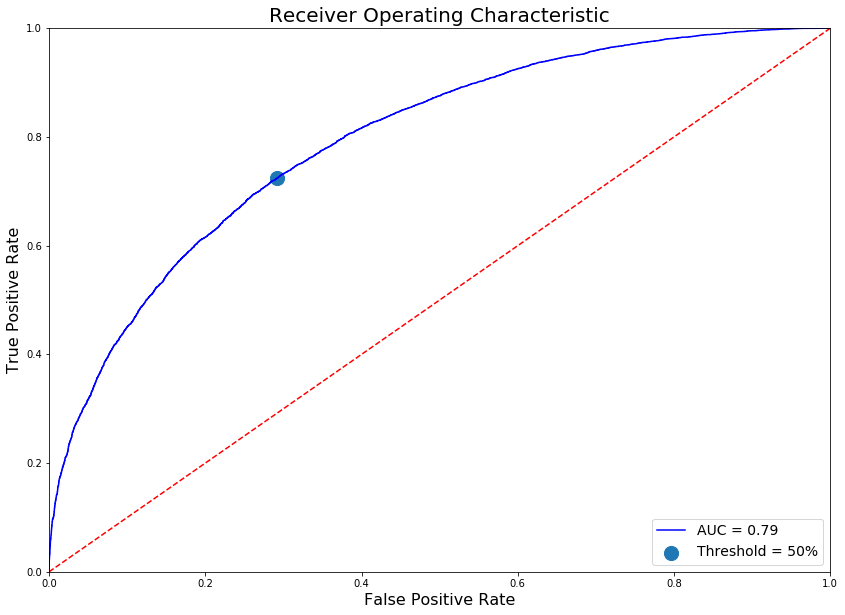

In [176]:
fpr, tpr, threshold = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(fpr[4200], tpr[4200], s=200, label='Threshold = 50%')
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

In [177]:
threshold[4200]

0.49502113286644395

### What about double predictions? (Up to this point, each team from each game has been treated and classified separately. That means there is probably some cases where neither team has been predicted to win, or both teams have been predicted to win!)

- Going to split the X dataframe so each game is only represented once, and append the predicted probability of each team winning, and then making a 'W_adj' columns (WinPrediction Adjusted) that will just use the larger of those two probabilities to predict a winning team

In [267]:
pred_proba = logreg.predict_proba(X)

In [268]:
preds = logreg.predict(X)

In [269]:
preds

array([0, 0, 0, ..., 0, 1, 1])

In [270]:
X['W'] = y

In [271]:
prob1 = []
for i in pred_proba:
    prob1.append(i[1])

In [272]:
X['prob1'] = prob1

In [273]:
X['orig_pred'] = preds

In [274]:
X.head(20)

0         1         2  \
school_id  date_game  opp_id                                                   
High Point 2011-11-18 Central Florida           3.790960 -6.081436 -1.205655   
           2011-11-22 Tennessee Tech            3.931356 -4.571748 -0.828146   
           2011-11-26 Citadel                   6.209464 -2.413404 -0.129863   
           2011-11-29 Hampton                   0.454386 -3.254574 -1.482772   
           2011-12-03 Campbell                  5.278938 -1.819610 -1.936405   
           2011-12-07 Wake Forest               5.232730 -2.315327 -0.397413   
           2011-12-17 Marshall                 -0.394789 -5.053176  0.909499   
           2011-12-21 Wofford                  -1.135603 -7.595600  1.792859   
           2011-12-31 Coastal Carolina         -0.086295 -3.248458  3.407372   
           2012-01-02 Charleston Southern       3.979149 -1.698766  0.273933   
           2012-01-05 Presbyterian             -2.686685 -4.473053  0.737687   
           2012-01-07 Gardner-Webb              2.227779 -2.633117  1.436479   
           2012-01-12 Winthrop                  2.602121 -3.356009  0.661743   
           2012-01-14 North Carolina-Asheville  3.461014 -1.002911 -0.567529   
           2012-01-17 Radford                   6.084863 -0.381955 -0.525944   
           2012-01-21 Liberty                   4.297638 -1.321976  2.850149   
           2012-01-26 North Carolina-Asheville  2.932958 -1.004966  0.205950   
           2012-01-28 Winthrop                  0.379896 -3.454074  0.077517   
           2012-02-02 Presbyterian              0.233945 -4.844226  0.662760   
           2012-02-04 Gardner-Webb              2.932141 -4.071538  0.504179   

                                                       3         4         5  \
school_id  date_game  opp_id                                                   
High Point 2011-11-18 Central Florida           0.215862  2.258905  0.954076   
           2011-11-22 Tennessee Tech            0.611397 -4.823761 -0.536561   
           2011-11-26 Citadel                  -1.072159  2.149813  0.434139   
           2011-11-29 Hampton                  -0.301871 -0.669659  0.866319   
           2011-12-03 Campbell                  4.385084 -1.638864  0.187775   
           2011-12-07 Wake Forest               0.304300  0.472577  1.286300   
           2011-12-17 Marshall                  4.140854  2.090304  3.520400   
           2011-12-21 Wofford                   2.453736  1.151321  2.714658   
           2011-12-31 Coastal Carolina         -0.924722  0.798661  1.534494   
           2012-01-02 Charleston Southern       0.802957  1.957876  0.869807   
           2012-01-05 Presbyterian              2.474396  1.973723  2.965594   
           2012-01-07 Gardner-Webb              0.824292 -0.133524 -1.174041   
           2012-01-12 Winthrop                 -0.475742 -5.002507 -1.073886   
           2012-01-14 North Carolina-Asheville  3.160555  1.833944  1.086198   
           2012-01-17 Radford                   4.501727 -0.704140 -1.218965   
           2012-01-21 Liberty                  -1.127357 -0.376801  3.538962   
           2012-01-26 North Carolina-Asheville  0.077291  0.277727  3.695930   
           2012-01-28 Winthrop                  0.446761 -4.020113  1.909397   
           2012-02-02 Presbyterian              0.723920  1.646606  2.917017   
           2012-02-04 Gardner-Webb              1.655241  1.161699  0.793891   

                                                       6         7         8  \
school_id  date_game  opp_id                                                   
High Point 2011-11-18 Central Florida          -1.209752  0.740085  0.972303   
           2011-11-22 Tennessee Tech           -1.679852 -1.790301 -1.487629   
           2011-11-26 Citadel                  -0.494764  1.703296 -1.207812   
           2011-11-29 Hampton                  -3.333138 -1.828650 -0.053367   
           2011-12-03 Campbell                 -3.209

In [275]:
X.reset_index(inplace=True)

In [276]:
X.sort_values(['date_game', 'school_id'], inplace=True)

In [277]:
X.reset_index(inplace=True, drop=True)

In [278]:
X.head()

,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,43,44,45,46,47,48,49,W,prob1,orig_pred
0,James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,...,-0.043270,-0.551345,1.010483,-0.619386,-0.544622,0.247181,-0.629163,1,0.353496,0
1,Virginia Commonwealth,2011-02-26,James Madison,-1.602078,-0.714932,2.932586,-0.468730,0.988985,-0.492004,0.011567,...,0.260726,-0.233975,-0.421070,0.049626,0.413916,-0.101832,-0.212004,0,0.735870,1
2,Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,...,0.232743,0.701626,0.654297,-0.369090,0.647283,0.021339,0.724774,1,0.578695,1
3,Loyola (IL),2011-03-01,Detroit Mercy,2.631673,-0.637230,1.151751,-2.029922,1.445821,-0.139568,-1.141033,...,0.116736,0.193651,0.086648,0.111976,0.915182,-0.408463,-0.135579,0,0.423026,0
4,Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,...,-0.355082,-0.822202,0.297925,0.120560,0.424661,-0.431176,-0.291449,0,0.424377,0


In [279]:
X.index[-1]

75354

In [280]:
# Will use the team_a and team_b lists below as masks to create separate 1-game only dataframes
team_a = []
team_b = []
for i in X.index:
    if i % 500 == 0:
        print('parsing...', i)
    if i not in team_b:
        for j in range(i, X.index[-1]):
            if X['school_id'][j] == X['opp_id'][i] and X['date_game'][i] == X['date_game'][j]:
                team_a.append(i)
                team_b.append(j)
                break

parsing... 0
parsing... 500
parsing... 1000
parsing... 1500
parsing... 2000
parsing... 2500
parsing... 3000
parsing... 3500
parsing... 4000
parsing... 4500
parsing... 5000
parsing... 5500
parsing... 6000
parsing... 6500
parsing... 7000
parsing... 7500
parsing... 8000
parsing... 8500
parsing... 9000
parsing... 9500
parsing... 10000
parsing... 10500
parsing... 11000
parsing... 11500
parsing... 12000
parsing... 12500
parsing... 13000
parsing... 13500
parsing... 14000
parsing... 14500
parsing... 15000
parsing... 15500
parsing... 16000
parsing... 16500
parsing... 17000
parsing... 17500
parsing... 18000
parsing... 18500
parsing... 19000
parsing... 19500
parsing... 20000
parsing... 20500
parsing... 21000
parsing... 21500
parsing... 22000
parsing... 22500
parsing... 23000
parsing... 23500
parsing... 24000
parsing... 24500
parsing... 25000
parsing... 25500
parsing... 26000
parsing... 26500
parsing... 27000
parsing... 27500
parsing... 28000
parsing... 28500
parsing... 29000
parsing... 29500
pars

In [281]:
print(len(team_a))
print(len(team_b))

37649
37649


In [282]:
X_team_a = X.loc[team_a]
X_team_b = X.loc[team_b]

In [283]:
X_team_a.head()

,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,43,44,45,46,47,48,49,W,prob1,orig_pred
0,James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,...,-0.043270,-0.551345,1.010483,-0.619386,-0.544622,0.247181,-0.629163,1,0.353496,0
2,Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,...,0.232743,0.701626,0.654297,-0.369090,0.647283,0.021339,0.724774,1,0.578695,1
4,Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,...,-0.355082,-0.822202,0.297925,0.120560,0.424661,-0.431176,-0.291449,0,0.424377,0
6,Belmont,2011-03-04,Mercer,-4.573900,4.045212,1.637228,5.285766,-5.217340,1.864890,-4.796025,...,-0.876660,-0.504840,0.329804,-0.482307,0.548959,-0.928676,-0.111121,1,0.872226,1
7,Cleveland State,2011-03-04,Wright State,-4.856683,-2.594846,0.701281,1.773014,-2.965519,0.624550,2.183951,...,0.038722,-0.077619,-0.216799,0.350359,-0.538032,-0.294808,-0.970589,1,0.625089,1


In [284]:
X_team_b.head()

,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,43,44,45,46,47,48,49,W,prob1,orig_pred
1,Virginia Commonwealth,2011-02-26,James Madison,-1.602078,-0.714932,2.932586,-0.468730,0.988985,-0.492004,0.011567,...,0.260726,-0.233975,-0.421070,0.049626,0.413916,-0.101832,-0.212004,0,0.735870,1
3,Loyola (IL),2011-03-01,Detroit Mercy,2.631673,-0.637230,1.151751,-2.029922,1.445821,-0.139568,-1.141033,...,0.116736,0.193651,0.086648,0.111976,0.915182,-0.408463,-0.135579,0,0.423026,0
5,Southern Illinois,2011-03-03,Illinois State,1.792110,-6.424995,-0.760293,-1.635151,-0.490843,-1.128347,2.227399,...,0.208640,0.241123,-0.355443,-0.462288,0.024345,-0.615390,-0.090747,1,0.523590,1
12,Mercer,2011-03-04,Belmont,-4.762402,-5.471940,-3.072437,4.896280,-3.375397,1.722534,-2.797522,...,0.135425,0.534518,0.237436,0.083091,-0.303649,0.513820,-0.592254,0,0.175594,0
19,Wright State,2011-03-04,Cleveland State,1.511035,-4.620702,1.719798,4.319319,-1.353540,-0.016617,1.631460,...,0.611268,-0.496073,0.697666,-0.000702,-0.339341,-0.039304,-0.822189,0,0.358468,0


In [285]:
prob_opp1 = []
for i in team_b:
    prob_opp1.append(X.loc[i, 'prob1'])

In [286]:
X_team_a['prob_opp1'] = prob_opp1

In [287]:
X_team_a.head()

,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,44,45,46,47,48,49,W,prob1,orig_pred,prob_opp1
0,James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,...,-0.551345,1.010483,-0.619386,-0.544622,0.247181,-0.629163,1,0.353496,0,0.735870
2,Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,...,0.701626,0.654297,-0.369090,0.647283,0.021339,0.724774,1,0.578695,1,0.423026
4,Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,...,-0.822202,0.297925,0.120560,0.424661,-0.431176,-0.291449,0,0.424377,0,0.523590
6,Belmont,2011-03-04,Mercer,-4.573900,4.045212,1.637228,5.285766,-5.217340,1.864890,-4.796025,...,-0.504840,0.329804,-0.482307,0.548959,-0.928676,-0.111121,1,0.872226,1,0.175594
7,Cleveland State,2011-03-04,Wright State,-4.856683,-2.594846,0.701281,1.773014,-2.965519,0.624550,2.183951,...,-0.077619,-0.216799,0.350359,-0.538032,-0.294808,-0.970589,1,0.625089,1,0.358468


In [288]:
W_adj = []
for i in X_team_a.index:
    if X_team_a.loc[i, 'prob1'] > X_team_a.loc[i, 'prob_opp1']:
        W_adj.append(1)
    else:
        W_adj.append(0)

In [289]:
X_team_a['W_adj'] = W_adj

In [290]:
X_team_a.head()

,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,45,46,47,48,49,W,prob1,orig_pred,prob_opp1,W_adj
0,James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,...,1.010483,-0.619386,-0.544622,0.247181,-0.629163,1,0.353496,0,0.735870,0
2,Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,...,0.654297,-0.369090,0.647283,0.021339,0.724774,1,0.578695,1,0.423026,1
4,Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,...,0.297925,0.120560,0.424661,-0.431176,-0.291449,0,0.424377,0,0.523590,0
6,Belmont,2011-03-04,Mercer,-4.573900,4.045212,1.637228,5.285766,-5.217340,1.864890,-4.796025,...,0.329804,-0.482307,0.548959,-0.928676,-0.111121,1,0.872226,1,0.175594,1
7,Cleveland State,2011-03-04,Wright State,-4.856683,-2.594846,0.701281,1.773014,-2.965519,0.624550,2.183951,...,-0.216799,0.350359,-0.538032,-0.294808,-0.970589,1,0.625089,1,0.358468,1


In [291]:
X_team_a.set_index(['school_id', 'date_game', 'opp_id'], inplace=True)

In [292]:
X_team_a['W'].sum()

18204

In [293]:
X_team_a['W_adj'].sum()

17999

### Original Prediction Accuracy

In [294]:
print(classification_report(X_team_a['W'], X_team_a['orig_pred']))
pd.DataFrame(confusion_matrix(X_team_a['W'], X_team_a['orig_pred']), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.73      0.73      0.73     19445
          1       0.71      0.70      0.71     18204

avg / total       0.72      0.72      0.72     37649



,Pred -,Pred +
Act -,14264,5181
Act +,5382,12822


### Prediction Accuracy after correcting for no-winner/two-winner predictions

In [295]:
print(classification_report(X_team_a['W'], X_team_a['W_adj']))
pd.DataFrame(confusion_matrix(X_team_a['W'], X_team_a['W_adj']), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.73      0.74      0.73     19445
          1       0.72      0.71      0.71     18204

avg / total       0.72      0.72      0.72     37649



,Pred -,Pred +
Act -,14320,5125
Act +,5330,12874


- Surprisingly only small increment in overall accuracy after correction

### Explore model performance for close matchups vs. expected blowout matchups

In [296]:
X_team_a

,,,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,W,prob1,orig_pred,prob_opp1,W_adj
school_id,date_game,opp_id,,,,,,,,,,,,,,,,,,,,,
James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,-0.258597,-0.513730,-0.133721,...,1.010483,-0.619386,-0.544622,0.247181,-0.629163,1,0.353496,0,0.735870,0
Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,1.535273,1.349560,2.008542,...,0.654297,-0.369090,0.647283,0.021339,0.724774,1,0.578695,1,0.423026,1
Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,0.941403,-1.236449,2.666863,...,0.297925,0.120560,0.424661,-0.431176,-0.291449,0,0.424377,0,0.523590,0
Belmont,2011-03-04,Mercer,-4.573900,4.045212,1.637228,5.285766,-5.217340,1.864890,-4.796025,1.786941,2.398051,-2.363847,...,0.329804,-0.482307,0.548959,-0.928676,-0.111121,1,0.872226,1,0.175594,1
Cleveland State,2011-03-04,Wright State,-4.856683,-2.594846,0.701281,1.773014,-2.965519,0.624550,2.183951,1.424992,-0.221964,-2.188795,...,-0.216799,0.350359,-0.538032,-0.294808,-0.970589,1,0.625089,1,0.358468,1
Creighton,2011-03-04,Northern Iowa,-2.409623,-2.522417,4.089095,-2.045359,-0.554044,-2.845065,3.940081,0.534667,-2.478058,1.602551,...,0.198227,0.044332,-0.047332,0.226901,0.737181,1,0.481895,0,0.490717,0
Detroit Mercy,2011-03-04,Valparaiso,-3.884735,2.693875,-6.774051,1.405036,0.218212,1.651169,0.036108,-1.423754,0.842732,0.653531,...,0.185295,-0.080448,0.745896,-0.122351,-0.082118,0,0.384180,0,0.612022,0
East Tennessee State,2011-03-04,North Florida,-1.627100,0.384972,-9.387124,5.832431,0.329331,1.379748,0.812526,-4.155313,3.597840,0.149096,...,0.510508,-0.101860,-0.359832,-0.356649,0.509031,0,0.661797,1,0.277166,1
Marist,2011-03-04,Niagara,5.298479,-5.176129,-0.156087,2.609233,-0.397501,0.857055,-1.184068,-1.930097,1.741058,2.181225,...,0.064618,0.383380,0.453061,-0.279427,-0.577826,1,0.428690,0,0.598047,0


In [306]:
X_team_a.reset_index(inplace=True)

In [307]:
X_team_a.set_index(['school_id', 'date_game', 'opp_id'], drop=False, inplace=True)

In [309]:
X_team_a = X_team_a.join(joined[['SRS', 'opp_SRS']], how='left', on=['school_id', 'date_game', 'opp_id'], rsuffix='_r')

- Will use the difference in Simple Rating System to determine 'closeness' of matchup

In [313]:
X_team_a['SRS_diff'] = abs(X_team_a['SRS'] - X_team_a['opp_SRS'])

In [315]:
X_team_a['SRS_diff'].describe()

count    37703.000000
mean         8.219596
std          6.747302
min          0.000000
25%          3.040000
50%          6.610000
75%         11.600000
max         50.350000
Name: SRS_diff, dtype: float64

In [323]:
diff_mask_0to5 = X_team_a['SRS_diff'] < 5
diff_mask_5to10 = (X_team_a['SRS_diff'] > 5) & (X_team_a['SRS_diff'] < 10)
diff_mask_10to20 = (X_team_a['SRS_diff'] > 10) & (X_team_a['SRS_diff'] < 20)
diff_mask_20to30 = (X_team_a['SRS_diff'] > 20) & (X_team_a['SRS_diff'] < 30)
diff_mask_30plus = X_team_a['SRS_diff'] > 30

In [325]:
X_team_a.head()

,,,school_id,date_game,opp_id,0,1,2,3,4,5,6,...,48,49,W,prob1,orig_pred,prob_opp1,W_adj,SRS,opp_SRS,SRS_diff
school_id,date_game,opp_id,,,,,,,,,,,,,,,,,,,,,
James Madison,2011-02-26,Virginia Commonwealth,James Madison,2011-02-26,Virginia Commonwealth,-1.126635,-0.315900,-0.732924,1.114919,4.413185,-2.859090,0.709293,...,0.247181,-0.629163,1,0.353496,0,0.735870,0,2.94,8.56,5.62
Detroit Mercy,2011-03-01,Loyola (IL),Detroit Mercy,2011-03-01,Loyola (IL),-4.309646,0.462461,-4.008595,-3.783444,1.136622,2.059967,1.488198,...,0.021339,0.724774,1,0.578695,1,0.423026,1,1.88,1.73,0.15
Illinois State,2011-03-03,Southern Illinois,Illinois State,2011-03-03,Southern Illinois,3.206396,-5.072742,-0.699457,0.307324,0.468525,-1.346195,2.464895,...,-0.431176,-0.291449,0,0.424377,0,0.523590,0,-3.37,-2.46,0.91
Belmont,2011-03-04,Mercer,Belmont,2011-03-04,Mercer,-4.573900,4.045212,1.637228,5.285766,-5.217340,1.864890,-4.796025,...,-0.928676,-0.111121,1,0.872226,1,0.175594,1,13.07,-4.08,17.15
Cleveland State,2011-03-04,Wright State,Cleveland State,2011-03-04,Wright State,-4.856683,-2.594846,0.701281,1.773014,-2.965519,0.624550,2.183951,...,-0.294808,-0.970589,1,0.625089,1,0.358468,1,7.59,3.22,4.37


In [326]:
X_team_a.drop(['school_id', 'date_game', 'opp_id'], axis=1, inplace=True)

In [329]:
drop_cols = ['W', 'prob1', 'orig_pred', 'prob_opp1', 'W_adj', 'SRS', 'opp_SRS', 'SRS_diff']

In [333]:
preds = logreg.predict(X_team_a[diff_mask_0to5].drop(drop_cols, axis=1))
print(classification_report(X_team_a[diff_mask_0to5]['W'], preds))
pd.DataFrame(confusion_matrix(X_team_a[diff_mask_0to5]['W'], preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.57      0.58      0.57      7472
          1       0.57      0.56      0.56      7381

avg / total       0.57      0.57      0.57     14853



,Pred -,Pred +
Act -,4312,3160
Act +,3241,4140


In [334]:
preds = logreg.predict(X_team_a[diff_mask_5to10].drop(drop_cols, axis=1))
print(classification_report(X_team_a[diff_mask_5to10]['W'], preds))
pd.DataFrame(confusion_matrix(X_team_a[diff_mask_5to10]['W'], preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.74      0.74      0.74      5624
          1       0.72      0.72      0.72      5238

avg / total       0.73      0.73      0.73     10862



,Pred -,Pred +
Act -,4187,1437
Act +,1488,3750


In [335]:
preds = logreg.predict(X_team_a[diff_mask_10to20].drop(drop_cols, axis=1))
print(classification_report(X_team_a[diff_mask_10to20]['W'], preds))
pd.DataFrame(confusion_matrix(X_team_a[diff_mask_10to20]['W'], preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.88      0.89      0.88      5016
          1       0.87      0.86      0.87      4477

avg / total       0.87      0.87      0.87      9493



,Pred -,Pred +
Act -,4462,554
Act +,633,3844


In [336]:
preds = logreg.predict(X_team_a[diff_mask_20to30].drop(drop_cols, axis=1))
print(classification_report(X_team_a[diff_mask_20to30]['W'], preds))
pd.DataFrame(confusion_matrix(X_team_a[diff_mask_20to30]['W'], preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1111
          1       0.97      0.97      0.97       959

avg / total       0.97      0.97      0.97      2070



,Pred -,Pred +
Act -,1078,33
Act +,31,928


In [337]:
preds = logreg.predict(X_team_a[diff_mask_30plus].drop(drop_cols, axis=1))
print(classification_report(X_team_a[diff_mask_30plus]['W'], preds))
pd.DataFrame(confusion_matrix(X_team_a[diff_mask_30plus]['W'], preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       241
          1       0.99      0.99      0.99       152

avg / total       0.99      0.99      0.99       393



,Pred -,Pred +
Act -,240,1
Act +,1,151


- Let's write an iteration that will correlate model accuracy with matchup 'closeness'

In [400]:
acc_list = []
pool_size = []
for i in range(5, 50, 5):
    mask = (X_team_a['SRS_diff'] < i) & (X_team_a['SRS_diff'] > i-5)
    preds = logreg.predict(X_team_a[mask].drop(drop_cols, axis=1))
    acc = accuracy_score(X_team_a[mask]['W'], preds)
    pool_size.append(len(preds))
    acc_list.append(acc)

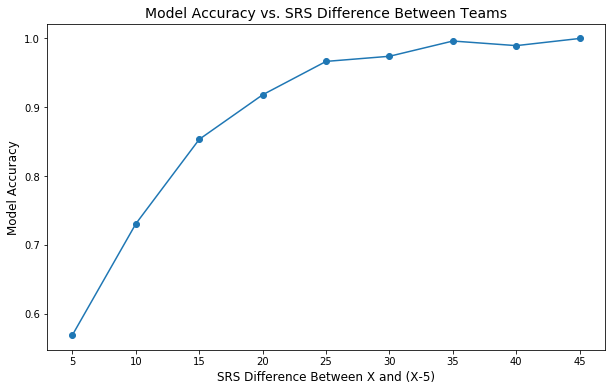

In [401]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(np.arange(5,50, 5), acc_list, marker='o')
plt.title('Model Accuracy vs. SRS Difference Between Teams', fontsize=14)
plt.xlabel('SRS Difference Between X and (X-5)', fontsize=12)
plt.ylabel('Model Accuracy', fontsize=12);

Text(0,0.5,'Sample Size')

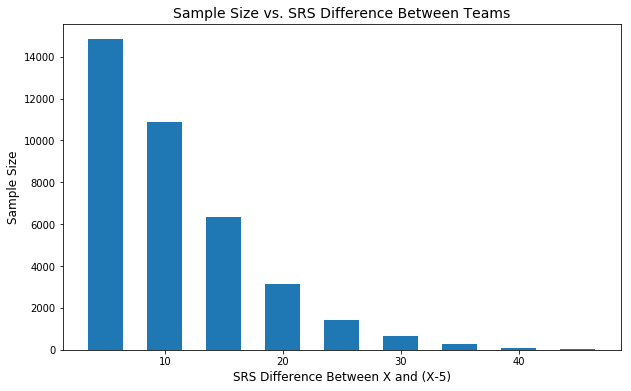

In [402]:
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(np.arange(5,50, 5), pool_size, 3, align='center')
plt.title('Sample Size vs. SRS Difference Between Teams', fontsize=14)
plt.xlabel('SRS Difference Between X and (X-5)', fontsize=12)
plt.ylabel('Sample Size', fontsize=12)

In [403]:
acc_list = []
for i in range(1, 50):
    mask = X_team_a['SRS_diff'] < i
    preds = logreg.predict(X_team_a[mask].drop(drop_cols, axis=1))
    acc = accuracy_score(X_team_a[mask]['W'], preds)
    acc_list.append(acc)

Text(0,0.5,'Model Accuracy')

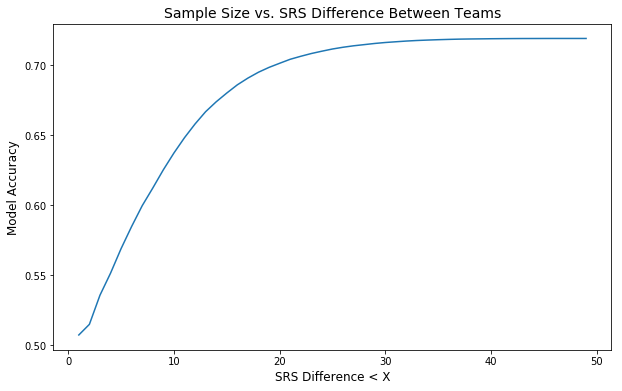

In [404]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(np.arange(1,50), acc_list)
plt.title('Sample Size vs. SRS Difference Between Teams', fontsize=14)
plt.xlabel('SRS Difference < X', fontsize=12)
plt.ylabel('Model Accuracy', fontsize=12)

# March Madness!

## Read in March Madness 2018 Results Data

In [69]:
page1 = pd.read_csv('../data/marchmadness_2018/scores_pg1.csv', sep='\t')
page2 = pd.read_csv('../data/marchmadness_2018/scores_pg2.csv', sep='\t')

In [70]:
page1.reset_index(inplace=True)

In [71]:
print(page1.shape)
print(page2.shape)

(100, 12)
(35, 12)


In [72]:
page1.columns = ['rank', 'year', 'date', 'region', 'round', 'school_id', 'pts', 'opp_id',
                'opp_pts', 'ot', 'pts_df', 'location']

page2.columns = ['rank', 'year', 'date', 'region', 'round', 'school_id', 'pts', 'opp_id',
                'opp_pts', 'ot', 'pts_df', 'location']

In [73]:
page2.drop(20, inplace=True)

In [74]:
mm_2018 = pd.concat([page1, page2], ignore_index=True)

In [75]:
mm_2018.reset_index(drop=True, inplace=True)

In [76]:
schools_list = []
opp_list = []
school_wins = []

remove_digits = str.maketrans('', '', digits)
for i in mm_2018.index:
    school_dirty = mm_2018['school_id'][i]
    school_clean = school_dirty.translate(remove_digits).lstrip()
    
    opp_dirty = mm_2018['opp_id'][i]
    opp_clean = opp_dirty.translate(remove_digits).lstrip()
    
    schools_list.append(school_clean)
    opp_list.append(opp_clean)
    
    if mm_2018['pts'][i] > mm_2018['opp_pts'][i]:
        school_wins.append(1)
    else:
        school_wins.append(0)

In [77]:
print(len(schools_list))
print(len(opp_list))
print(len(school_wins))

134
134
134


In [78]:
mm_2018['school_id'] = schools_list
mm_2018['opp_id'] = opp_list
mm_2018['W'] = school_wins

In [79]:
mm_2018.head()

,rank,year,date,region,round,school_id,pts,opp_id,opp_pts,ot,pts_df,location,W
0,1,2018,"April 2, 2018",National,National Final,Villanova,79,Michigan,62,NaN,17,"San Antonio, TX",1
1,2,2018,"April 2, 2018",National,National Final,Michigan,62,Villanova,79,NaN,-17,"San Antonio, TX",0
2,3,2018,"March 31, 2018",National,National Semifinal,Villanova,95,Kansas,79,NaN,16,"San Antonio, TX",1
3,4,2018,"March 31, 2018",National,National Semifinal,Michigan,69,Loyola (IL),57,NaN,12,"San Antonio, TX",1
4,5,2018,"March 31, 2018",National,National Semifinal,Loyola (IL),57,Michigan,69,NaN,-12,"San Antonio, TX",0


In [80]:
notin_list = []
for team in mm_2018['school_id']:
    if team not in df['school_id'].unique():
        notin_list.append(team)

In [81]:
# Good, looks like all schools are included
notin_list

[]

In [82]:
mm_2018['rank'] = mm_2018['rank'].apply(lambda x: int(x))
mm_2018.sort_values('rank', inplace=True, ascending=False)
mm_2018.reset_index(drop=True, inplace=True)

In [83]:
mm_2018['date'] = pd.to_datetime(mm_2018['date'])

In [84]:
mm_2018.dtypes

rank                  int64
year                 object
date         datetime64[ns]
region               object
round                object
school_id            object
pts                  object
opp_id               object
opp_pts              object
ot                   object
pts_df               object
location             object
W                     int64
dtype: object

In [86]:
yourteam_ewm_df.head()

,date_game,ewm03heldto_fg2,ewm03heldto_fg2a,ewm03heldto_fg3,ewm03heldto_fg3a,ewm03heldto_ft,ewm03heldto_fta,ewm03heldto_orb,ewm03heldto_drb,ewm03heldto_ast,...,rm30heldto_ast,rm30heldto_stl,rm30heldto_blk,rm30heldto_tov,rm30heldto_pf,rm30heldto_pts,rm30heldto_game_score,rm30heldto_W,heldto_opp_id,heldto_school_id
0,2010-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Old Dominion
1,2010-11-23,19.000000,36.000000,7.000000,19.000000,20.000000,34.000000,17.000000,27.000000,19.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Citadel
2,2010-11-28,18.333333,40.000000,5.666667,17.000000,20.000000,31.333333,15.666667,26.333333,17.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Hampton
3,2010-12-02,16.428571,39.428571,4.714286,13.571429,24.571429,35.142857,10.714286,26.714286,11.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,Gardner-Webb
4,2010-12-04,18.866667,38.666667,2.200000,14.333333,23.200000,34.533333,11.933333,26.333333,6.866667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Point,North Carolina-Asheville


In [87]:
yourteam_ewm_df.set_index(['heldto_opp_id', 'date_game', 'heldto_school_id'], inplace=True)
yourteam_ewm_df.head()

ewm03heldto_fg2  \
heldto_opp_id date_game  heldto_school_id                            
High Point    2010-11-15 Old Dominion                          NaN   
              2010-11-23 Citadel                         19.000000   
              2010-11-28 Hampton                         18.333333   
              2010-12-02 Gardner-Webb                    16.428571   
              2010-12-04 North Carolina-Asheville        18.866667   

                                                   ewm03heldto_fg2a  \
heldto_opp_id date_game  heldto_school_id                             
High Point    2010-11-15 Old Dominion                           NaN   
              2010-11-23 Citadel                          36.000000   
              2010-11-28 Hampton                          40.000000   
              2010-12-02 Gardner-Webb                     39.428571   
              2010-12-04 North Carolina-Asheville         38.666667   

                                                   ewm03heldto_fg3  \
heldto_opp_id date_game  heldto_school_id                            
High Point    2010-11-15 Old Dominion                          NaN   
              2010-11-23 Citadel                          7.000000   
              2010-11-28 Hampton                          5.666667   
              2010-12-02 Gardner-Webb                     4.714286   
              2010-12-04 North Carolina-Asheville         2.200000   

                                                   ewm03heldto_fg3a  \
heldto_opp_id date_game  heldto_school_id                             
High Point    2010-11-15 Old Dominion                           NaN   
              2010-11-23 Citadel                          19.000000   
              2010-11-28 Hampton                          17.000000   
              2010-12-02 Gardner-Webb                     13.571429   
              2010-12-04 North Carolina-Asheville         14.333333   

                                                   ewm03heldto_ft  \
heldto_opp_id date_game  heldto_school_id                           
High Point    2010-11-15 Old Dominion                         NaN   
              2010-11-23 Citadel                        20.000000   
              2010-11-28 Hampton                        20.000000   
              2010-12-02 Gardner-Webb                   24.571429   
              2010-12-04 North Carolina-Asheville       23.200000   

                                                   ewm03heldto_fta  \
heldto_opp_id date_game  heldto_school_id                            
High Point    2010-11-15 Old Dominion                          NaN   
              2010-11-23 Citadel                         34.000000   
              2010-11-28 Hampton                         31.333333   
              2010-12-02 Gardner-Webb                    35.142857   
              2010-12-04 North Carolina-Asheville        34.533333   

                                                   ewm03heldto_orb  \
heldto_opp_id date_game  heldto_school_id                            
High Point    2010-11-15 Old Dominion                          NaN   
              2010-11-23 Citadel                         17.000000   
              2010-11-28 Hampton                         15.666667   
              2010-12-02 Gardner-Webb                    10.714286   
              2010-12-04 North Carolina-Asheville        11.933333   

                                                   ewm03heldto_drb  \
heldto_opp_id date_game  heldto_school_id                            
High Point    2010-11-15 Old Dominion                          NaN   
              2010-11-23 Citadel                         27.000000   
              2010-11-28 Hampton                         26.333333   
              2010-12-02 Gardner-Webb                    26.714286   
              2010-12-04 North Carolina-Asheville        26.333333   

                                                   ewm03heldto_ast  \
heldto_opp_id date_game  heldto_school_id     

In [88]:
yourteam_ewm_df.shape

(87171, 64)

In [89]:
# I will use this function to find the most recent predictors for a given team and opponent, 
# and transform them into a form that can by passed to .predict() (Will still need a PCA transform)

def row_maker(school, opp):
    school_max_date = joined.loc[school].index.max()[0]
    opp_max_date = joined.loc[opp].index.max()[0]
    last_school_opp_played = joined.loc[opp, opp_max_date].index[0]
    
    row = pd.concat([joined.loc[school, school_max_date][joined.columns[0:64]].reset_index(drop=True),
                     yourteam_ewm_df.loc[opp, opp_max_date][joined.columns[64:128]].reset_index(drop=True),
                     joined.loc[school, school_max_date][joined.columns[129:131]].reset_index(drop=True),
                     joined.loc[last_school_opp_played, opp_max_date][joined.columns[131:133]].reset_index(drop=True).rename(columns={'SRS':'opp_SRS', 'SOS':'opp_SOS'})], 
                    axis=1)
    
    return(row)

In [95]:
row_maker('Villanova', 'Gonzaga')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


,ewm03fg2,ewm03fg2a,ewm03fg3,ewm03fg3a,ewm03ft,ewm03fta,ewm03orb,ewm03drb,ewm03ast,ewm03stl,...,rm30heldto_blk,rm30heldto_tov,rm30heldto_pf,rm30heldto_pts,rm30heldto_game_score,rm30heldto_W,SRS,SOS,opp_SRS,opp_SOS
0,18.276098,31.72426,9.604891,34.158518,12.312282,15.724386,7.579961,29.365736,14.844208,6.940066,...,2.733333,12.0,17.966667,66.366667,40.2,0.133333,25.69,9.51,19.43,2.05


In [91]:
first4_indices = np.arange(0, 8, 1)
firstround_indices = np.arange(8, 72, 1)
secondround_indices = np.arange(72, 104, 1)
sweet16_indices = np.arange(104, 120, 1)
regional_indices = np.arange(120, 128, 1)
final4_indices = np.arange(128, 132, 1)
final_indices = np.arange(132, 134, 1)

## First 4 (Small sample size, will skip to Round of 64)

In [99]:
list(joined[cols_interest].columns.drop('W'))

['ewm03fg2',
 'ewm03fg2a',
 'ewm03fg3',
 'ewm03fg3a',
 'ewm03ft',
 'ewm03fta',
 'ewm03orb',
 'ewm03drb',
 'ewm03ast',
 'ewm03stl',
 'ewm03blk',
 'ewm03tov',
 'ewm03pf',
 'ewm03pts',
 'ewm03game_score',
 'ewm03W',
 'ewm10fg2',
 'ewm10fg2a',
 'ewm10fg3',
 'ewm10fg3a',
 'ewm10ft',
 'ewm10fta',
 'ewm10orb',
 'ewm10drb',
 'ewm10ast',
 'ewm10stl',
 'ewm10blk',
 'ewm10tov',
 'ewm10pf',
 'ewm10pts',
 'ewm10game_score',
 'ewm10W',
 'ewm20fg2',
 'ewm20fg2a',
 'ewm20fg3',
 'ewm20fg3a',
 'ewm20ft',
 'ewm20fta',
 'ewm20orb',
 'ewm20drb',
 'ewm20ast',
 'ewm20stl',
 'ewm20blk',
 'ewm20tov',
 'ewm20pf',
 'ewm20pts',
 'ewm20game_score',
 'ewm20W',
 'rm30fg2',
 'rm30fg2a',
 'rm30fg3',
 'rm30fg3a',
 'rm30ft',
 'rm30fta',
 'rm30orb',
 'rm30drb',
 'rm30ast',
 'rm30stl',
 'rm30blk',
 'rm30tov',
 'rm30pf',
 'rm30pts',
 'rm30game_score',
 'rm30W',
 'ewm03heldto_fg2',
 'ewm03heldto_fg2a',
 'ewm03heldto_fg3',
 'ewm03heldto_fg3a',
 'ewm03heldto_ft',
 'ewm03heldto_fta',
 'ewm03heldto_orb',
 'ewm03heldto_drb',
 'e

In [100]:
# Predictions of 'First 4' Round
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))

for i in first4_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [101]:
temp_df.head()

,ewm03fg2,ewm03fg2a,ewm03fg3,ewm03fg3a,ewm03ft,ewm03fta,ewm03orb,ewm03drb,ewm03ast,ewm03stl,...,rm30heldto_blk,rm30heldto_tov,rm30heldto_pf,rm30heldto_pts,rm30heldto_game_score,rm30heldto_W,SRS,SOS,opp_SRS,opp_SOS
0,19.464439,38.541300,8.363637,23.333603,14.118672,18.806094,9.765023,24.428142,14.267817,7.090887,...,3.233333,12.366667,16.600000,64.733333,43.346667,0.366667,-8.07,-7.95,-2.80,-4.86
1,12.182554,30.475783,6.740194,20.152899,17.776831,23.375873,8.385887,21.341574,9.050584,8.079269,...,2.600000,11.600000,20.300000,76.366667,52.573333,0.466667,-2.80,-4.86,-8.07,-7.95
2,18.569016,37.216551,10.200230,26.423701,26.933218,35.051640,8.634982,27.300025,13.467563,6.375908,...,2.533333,10.366667,19.266667,76.700000,53.990000,0.366667,8.99,2.08,12.85,7.26
3,14.154674,33.709910,13.082887,30.488459,10.410688,14.294333,10.544453,27.777052,13.861189,4.294711,...,4.066667,14.366667,19.333333,71.033333,46.330000,0.233333,12.85,7.26,8.99,2.08
4,19.024548,35.746044,8.091326,23.473566,18.612476,25.684790,5.570342,20.392013,13.012902,7.735302,...,3.200000,12.033333,18.033333,63.100000,44.660000,0.400000,15.01,6.81,12.25,9.25


In [102]:
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50), index=mm_2018['school_id'][first4_indices])

In [103]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
school_id,,,,,,,,,,,,,,,,,,,,,
Long Island University,9.540127,241.171095,-36.459663,22.602504,-10.470830,64.245706,-44.876218,-11.743921,-60.719648,-0.056786,...,-8.429417,-1.013193,-5.862115,-12.972440,3.566506,8.364861,-7.482796,7.866680,-3.764180,-4.264803
Radford,50.857581,243.047903,-40.136786,39.219900,10.041820,57.303718,-36.892919,-26.522902,-57.621586,-13.013492,...,-9.472732,-1.132636,-5.101023,-13.407801,3.885530,6.094290,-4.948578,7.303678,-7.322891,-3.607076
St. Bonaventure,29.908289,287.566449,-39.272487,20.986849,-4.654294,68.352169,-32.831351,-22.561408,-58.808890,-16.913940,...,-10.184302,0.586987,-7.361391,-21.752347,-5.837661,7.771416,-8.657756,8.343377,-10.900885,-4.799654
UCLA,34.830110,276.652273,-27.847480,31.723937,-7.626652,53.760068,-44.773539,-31.627099,-65.048351,-8.863110,...,-7.398131,-3.561889,-6.131164,-18.175896,2.343986,7.610969,-3.692386,9.670743,-8.867707,-3.587957
Arizona State,-1.922230,246.725978,-31.704830,21.403800,-10.733528,62.944306,-39.747360,-13.149720,-48.969001,-9.376549,...,-9.152726,9.437008,-6.078325,-12.051217,0.618152,8.119512,-6.161723,6.796194,-0.580993,-5.902075
North Carolina Central,50.453110,262.663933,-51.633619,32.812932,21.500071,59.156246,-46.893088,-21.353568,-75.697525,-8.830596,...,-8.776067,-2.649148,-4.556864,-17.893415,-0.313454,6.315918,-3.623204,4.661024,-7.363551,-4.846129
Syracuse,60.804143,219.127619,-41.451305,32.644423,10.464009,40.066680,-31.324162,-47.071900,-48.500300,-14.544136,...,-6.328762,-3.783255,-4.808738,-6.667394,1.958373,5.974313,0.748197,2.505210,-0.333015,-1.585369
Texas Southern,29.838455,269.683330,-44.237627,28.663489,-4.521232,64.129840,-31.661811,-12.539519,-62.679467,-13.328357,...,-14.636568,0.258513,-5.308030,-13.449174,2.737086,7.637617,-7.515619,8.244238,-8.433515,-2.771653


In [104]:
temp_df['W'] = mm_2018['W'][first4_indices].values

In [105]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,W
school_id,,,,,,,,,,,,,,,,,,,,,
Long Island University,9.540127,241.171095,-36.459663,22.602504,-10.470830,64.245706,-44.876218,-11.743921,-60.719648,-0.056786,...,-1.013193,-5.862115,-12.972440,3.566506,8.364861,-7.482796,7.866680,-3.764180,-4.264803,0
Radford,50.857581,243.047903,-40.136786,39.219900,10.041820,57.303718,-36.892919,-26.522902,-57.621586,-13.013492,...,-1.132636,-5.101023,-13.407801,3.885530,6.094290,-4.948578,7.303678,-7.322891,-3.607076,1
St. Bonaventure,29.908289,287.566449,-39.272487,20.986849,-4.654294,68.352169,-32.831351,-22.561408,-58.808890,-16.913940,...,0.586987,-7.361391,-21.752347,-5.837661,7.771416,-8.657756,8.343377,-10.900885,-4.799654,1
UCLA,34.830110,276.652273,-27.847480,31.723937,-7.626652,53.760068,-44.773539,-31.627099,-65.048351,-8.863110,...,-3.561889,-6.131164,-18.175896,2.343986,7.610969,-3.692386,9.670743,-8.867707,-3.587957,0
Arizona State,-1.922230,246.725978,-31.704830,21.403800,-10.733528,62.944306,-39.747360,-13.149720,-48.969001,-9.376549,...,9.437008,-6.078325,-12.051217,0.618152,8.119512,-6.161723,6.796194,-0.580993,-5.902075,0
North Carolina Central,50.453110,262.663933,-51.633619,32.812932,21.500071,59.156246,-46.893088,-21.353568,-75.697525,-8.830596,...,-2.649148,-4.556864,-17.893415,-0.313454,6.315918,-3.623204,4.661024,-7.363551,-4.846129,0
Syracuse,60.804143,219.127619,-41.451305,32.644423,10.464009,40.066680,-31.324162,-47.071900,-48.500300,-14.544136,...,-3.783255,-4.808738,-6.667394,1.958373,5.974313,0.748197,2.505210,-0.333015,-1.585369,1
Texas Southern,29.838455,269.683330,-44.237627,28.663489,-4.521232,64.129840,-31.661811,-12.539519,-62.679467,-13.328357,...,0.258513,-5.308030,-13.449174,2.737086,7.637617,-7.515619,8.244238,-8.433515,-2.771653,1


In [106]:
temp_df['pred'] = logreg.predict(temp_df.drop('W', axis=1))

In [107]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,W,pred
school_id,,,,,,,,,,,,,,,,,,,,,
Long Island University,9.540127,241.171095,-36.459663,22.602504,-10.470830,64.245706,-44.876218,-11.743921,-60.719648,-0.056786,...,-5.862115,-12.972440,3.566506,8.364861,-7.482796,7.866680,-3.764180,-4.264803,0,0
Radford,50.857581,243.047903,-40.136786,39.219900,10.041820,57.303718,-36.892919,-26.522902,-57.621586,-13.013492,...,-5.101023,-13.407801,3.885530,6.094290,-4.948578,7.303678,-7.322891,-3.607076,1,1
St. Bonaventure,29.908289,287.566449,-39.272487,20.986849,-4.654294,68.352169,-32.831351,-22.561408,-58.808890,-16.913940,...,-7.361391,-21.752347,-5.837661,7.771416,-8.657756,8.343377,-10.900885,-4.799654,1,0
UCLA,34.830110,276.652273,-27.847480,31.723937,-7.626652,53.760068,-44.773539,-31.627099,-65.048351,-8.863110,...,-6.131164,-18.175896,2.343986,7.610969,-3.692386,9.670743,-8.867707,-3.587957,0,1
Arizona State,-1.922230,246.725978,-31.704830,21.403800,-10.733528,62.944306,-39.747360,-13.149720,-48.969001,-9.376549,...,-6.078325,-12.051217,0.618152,8.119512,-6.161723,6.796194,-0.580993,-5.902075,0,1
North Carolina Central,50.453110,262.663933,-51.633619,32.812932,21.500071,59.156246,-46.893088,-21.353568,-75.697525,-8.830596,...,-4.556864,-17.893415,-0.313454,6.315918,-3.623204,4.661024,-7.363551,-4.846129,0,0
Syracuse,60.804143,219.127619,-41.451305,32.644423,10.464009,40.066680,-31.324162,-47.071900,-48.500300,-14.544136,...,-4.808738,-6.667394,1.958373,5.974313,0.748197,2.505210,-0.333015,-1.585369,1,1
Texas Southern,29.838455,269.683330,-44.237627,28.663489,-4.521232,64.129840,-31.661811,-12.539519,-62.679467,-13.328357,...,-5.308030,-13.449174,2.737086,7.637617,-7.515619,8.244238,-8.433515,-2.771653,1,1


## Round of 64!!

In [108]:
# Predictions of Round of 64
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))

for i in firstround_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [109]:
temp_df.head()

,ewm03fg2,ewm03fg2a,ewm03fg3,ewm03fg3a,ewm03ft,ewm03fta,ewm03orb,ewm03drb,ewm03ast,ewm03stl,...,rm30heldto_blk,rm30heldto_tov,rm30heldto_pf,rm30heldto_pts,rm30heldto_game_score,rm30heldto_W,SRS,SOS,opp_SRS,opp_SOS
0,14.606253,35.209370,6.203352,20.174698,14.478572,23.195259,12.198405,23.804580,11.322627,5.270271,...,3.833333,12.600000,17.133333,71.533333,49.576667,0.333333,12.95,10.56,14.88,6.91
1,24.149661,39.915515,5.244414,15.321979,15.866382,22.482221,10.415164,24.902106,14.680228,2.577373,...,3.800000,13.133333,18.900000,77.400000,52.233333,0.300000,16.92,7.21,7.62,-0.56
2,22.477343,37.735815,8.642777,21.875473,17.534910,24.147385,9.235692,24.649027,17.464014,5.655192,...,2.700000,11.266667,19.600000,72.366667,48.566667,0.233333,7.62,-0.56,16.92,7.21
3,17.704589,31.976465,12.004080,29.355071,22.096391,25.639403,6.710272,29.787052,17.331633,4.263822,...,3.800000,11.600000,20.266667,70.866667,46.986667,0.300000,11.24,2.37,17.60,11.16
4,16.255005,30.084500,6.719441,24.192032,12.994554,16.121814,10.220994,26.339369,13.933141,7.982132,...,2.733333,12.600000,16.966667,76.100000,54.320000,0.366667,25.00,9.91,0.96,-2.74


In [110]:
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

In [111]:
temp_df['school_id'] = mm_2018['school_id'][firstround_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][firstround_indices].values

In [112]:
temp_df['W'] = mm_2018['W'][firstround_indices].values

In [113]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,school_id,opp_id,W
0,33.598022,245.350623,-38.389682,10.363170,-3.723563,55.159348,-38.368237,-30.748003,-51.478447,-3.982511,...,-14.803693,0.064334,5.507523,0.053040,3.040529,-2.268678,-2.430810,Alabama,Virginia Tech,1
1,27.786856,276.675822,-48.530684,30.255525,3.346603,49.772580,-38.946294,-26.380955,-67.998022,-12.386208,...,-15.581031,1.755392,7.584860,-10.560670,10.082871,-3.942758,-3.587291,Arizona,Buffalo,0
2,16.046644,280.148698,-37.322316,34.660246,4.466834,63.569757,-45.047400,-19.178693,-67.897782,-14.428414,...,-16.429077,-1.983916,8.212792,-13.307511,10.363768,-7.015636,-3.960915,Buffalo,Arizona,1
3,20.873416,272.122624,-17.747289,36.160316,-1.855437,59.184644,-43.962470,-29.796051,-59.123863,-12.781176,...,-18.221286,1.932633,5.402856,-13.823063,14.929490,-9.295761,-6.379575,Davidson,Kentucky,0
4,23.612909,267.853284,-36.275817,32.671254,12.561662,53.492959,-43.387755,-22.304488,-59.350779,-3.673833,...,-11.603822,3.132943,13.405418,-6.919331,10.934155,-1.283155,-5.826781,Duke,Iona,1
5,42.257265,262.349375,-32.534600,28.238489,-2.924802,45.341052,-42.078248,-34.861275,-60.214260,-17.241359,...,-20.094537,4.511320,5.015703,-2.370107,5.775863,-8.579475,-1.152278,Florida,St. Bonaventure,1
6,10.501977,228.039146,-25.277054,25.312086,-8.708946,41.862111,-39.364771,-18.296676,-53.571191,-3.265383,...,-6.705289,3.274517,9.090109,-7.526099,11.755750,3.625121,-3.146321,Gonzaga,North Carolina-Greensboro,1
7,15.327976,258.049299,-25.903061,28.080496,-8.933283,52.182516,-55.332472,-19.587852,-65.811553,-6.511329,...,-13.722319,3.320697,7.805666,-10.615539,9.316942,-3.835425,-7.648572,Houston,San Diego State,1
8,17.723289,238.299003,-29.679412,26.222909,8.241416,59.952865,-41.006155,-26.459420,-52.812561,-10.423449,...,-9.674698,5.064064,5.756681,-5.847331,12.321223,-2.251862,-0.906256,Iona,Duke,0
9,16.310095,268.360310,-29.466264,43.767863,8.213099,45.124887,-44.753045,-15.907371,-67.886048,-8.260722,...,-17.109221,1.466113,4.654989,-10.005051,12.812209,-5.431302,-3.793904,Kansas,Pennsylvania,1


In [114]:
temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

In [115]:
pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

In [116]:
pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])

In [117]:
temp_df['pred_proba'] = pred_proba_list

In [118]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,school_id,opp_id,W,pred,pred_proba
0,33.598022,245.350623,-38.389682,10.363170,-3.723563,55.159348,-38.368237,-30.748003,-51.478447,-3.982511,...,5.507523,0.053040,3.040529,-2.268678,-2.430810,Alabama,Virginia Tech,1,1,0.939892
1,27.786856,276.675822,-48.530684,30.255525,3.346603,49.772580,-38.946294,-26.380955,-67.998022,-12.386208,...,7.584860,-10.560670,10.082871,-3.942758,-3.587291,Arizona,Buffalo,0,1,0.999999
2,16.046644,280.148698,-37.322316,34.660246,4.466834,63.569757,-45.047400,-19.178693,-67.897782,-14.428414,...,8.212792,-13.307511,10.363768,-7.015636,-3.960915,Buffalo,Arizona,1,0,0.002175
3,20.873416,272.122624,-17.747289,36.160316,-1.855437,59.184644,-43.962470,-29.796051,-59.123863,-12.781176,...,5.402856,-13.823063,14.929490,-9.295761,-6.379575,Davidson,Kentucky,0,0,0.013002
4,23.612909,267.853284,-36.275817,32.671254,12.561662,53.492959,-43.387755,-22.304488,-59.350779,-3.673833,...,13.405418,-6.919331,10.934155,-1.283155,-5.826781,Duke,Iona,1,1,1.000000


In [119]:
pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])

In [120]:
temp_df['pred_proba_opp'] = pred_proba_opp

In [121]:
W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)

In [122]:
temp_df['W_adj'] = W_adj

In [123]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,school_id,opp_id,W,pred,pred_proba,pred_proba_opp,W_adj
0,33.598022,245.350623,-38.389682,10.363170,-3.723563,55.159348,-38.368237,-30.748003,-51.478447,-3.982511,...,3.040529,-2.268678,-2.430810,Alabama,Virginia Tech,1,1,0.939892,7.118675e-01,1
1,27.786856,276.675822,-48.530684,30.255525,3.346603,49.772580,-38.946294,-26.380955,-67.998022,-12.386208,...,10.082871,-3.942758,-3.587291,Arizona,Buffalo,0,1,0.999999,2.174742e-03,1
2,16.046644,280.148698,-37.322316,34.660246,4.466834,63.569757,-45.047400,-19.178693,-67.897782,-14.428414,...,10.363768,-7.015636,-3.960915,Buffalo,Arizona,1,0,0.002175,9.999987e-01,0
3,20.873416,272.122624,-17.747289,36.160316,-1.855437,59.184644,-43.962470,-29.796051,-59.123863,-12.781176,...,14.929490,-9.295761,-6.379575,Davidson,Kentucky,0,0,0.013002,9.999959e-01,0
4,23.612909,267.853284,-36.275817,32.671254,12.561662,53.492959,-43.387755,-22.304488,-59.350779,-3.673833,...,10.934155,-1.283155,-5.826781,Duke,Iona,1,1,1.000000,2.365850e-09,1


In [124]:
print(classification_report(temp_df['W'], temp_df['pred']))
pd.DataFrame(confusion_matrix(temp_df['W'], temp_df['pred']), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.77      0.62      0.69        32
          1       0.68      0.81      0.74        32

avg / total       0.73      0.72      0.72        64



,Pred -,Pred +
Act -,20,12
Act +,6,26


In [125]:
print(classification_report(temp_df['W'], temp_df['W_adj']))
pd.DataFrame(confusion_matrix(temp_df['W'], temp_df['W_adj']), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.72      0.72      0.72        32
          1       0.72      0.72      0.72        32

avg / total       0.72      0.72      0.72        64



,Pred -,Pred +
Act -,23,9
Act +,9,23


In [126]:
incorrect_picks = []
for i in temp_df.index:
    if temp_df['W'][i] != temp_df['W_adj'][i]:
        incorrect_picks.append(temp_df['school_id'][i])

In [127]:
incorrect_picks

['Arizona',
 'Buffalo',
 'Loyola (IL)',
 'Miami (FL)',
 'Oklahoma',
 'Rhode Island',
 'Creighton',
 'Florida State',
 'Kansas State',
 'Marshall',
 'Maryland-Baltimore County',
 'Missouri',
 'Nevada',
 'Syracuse',
 'Texas',
 'Texas Christian',
 'Virginia',
 'Wichita State']

In [128]:
len(incorrect_picks)

18

In [129]:
correct_picks = []
for i in temp_df.index:
    if temp_df['W'][i] == temp_df['W_adj'][i]:
        correct_picks.append(temp_df['school_id'][i])

In [130]:
correct_picks

['Alabama',
 'Davidson',
 'Duke',
 'Florida',
 'Gonzaga',
 'Houston',
 'Iona',
 'Kansas',
 'Kentucky',
 'Michigan',
 'Montana',
 'North Carolina-Greensboro',
 'North Carolina State',
 'Ohio State',
 'Pennsylvania',
 'Radford',
 'San Diego State',
 'Seton Hall',
 'South Dakota State',
 'St. Bonaventure',
 'Stephen F. Austin',
 'Tennessee',
 'Texas Tech',
 'Villanova',
 'Virginia Tech',
 'Wright State',
 'Arkansas',
 'Auburn',
 'Bucknell',
 'Butler',
 'Cal State Fullerton',
 'Cincinnati',
 'Clemson',
 'College of Charleston',
 'Georgia State',
 'Lipscomb',
 'Michigan State',
 'Murray State',
 'New Mexico State',
 'North Carolina',
 'Providence',
 'Purdue',
 'Texas A&M',
 'Texas Southern',
 'West Virginia',
 'Xavier']

In [131]:
len(correct_picks)

46

In [132]:
temp_df.loc[:30].sort_values('school_id')

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,school_id,opp_id,W,pred,pred_proba,pred_proba_opp,W_adj
0,33.598022,245.350623,-38.389682,10.363170,-3.723563,55.159348,-38.368237,-30.748003,-51.478447,-3.982511,...,3.040529,-2.268678,-2.430810,Alabama,Virginia Tech,1,1,9.398920e-01,7.118675e-01,1
1,27.786856,276.675822,-48.530684,30.255525,3.346603,49.772580,-38.946294,-26.380955,-67.998022,-12.386208,...,10.082871,-3.942758,-3.587291,Arizona,Buffalo,0,1,9.999987e-01,2.174742e-03,1
2,16.046644,280.148698,-37.322316,34.660246,4.466834,63.569757,-45.047400,-19.178693,-67.897782,-14.428414,...,10.363768,-7.015636,-3.960915,Buffalo,Arizona,1,0,2.174742e-03,9.999987e-01,0
3,20.873416,272.122624,-17.747289,36.160316,-1.855437,59.184644,-43.962470,-29.796051,-59.123863,-12.781176,...,14.929490,-9.295761,-6.379575,Davidson,Kentucky,0,0,1.300207e-02,9.999959e-01,0
4,23.612909,267.853284,-36.275817,32.671254,12.561662,53.492959,-43.387755,-22.304488,-59.350779,-3.673833,...,10.934155,-1.283155,-5.826781,Duke,Iona,1,1,1.000000e+00,2.365850e-09,1
5,42.257265,262.349375,-32.534600,28.238489,-2.924802,45.341052,-42.078248,-34.861275,-60.214260,-17.241359,...,5.775863,-8.579475,-1.152278,Florida,St. Bonaventure,1,1,9.999907e-01,1.810928e-03,1
6,10.501977,228.039146,-25.277054,25.312086,-8.708946,41.862111,-39.364771,-18.296676,-53.571191,-3.265383,...,11.755750,3.625121,-3.146321,Gonzaga,North Carolina-Greensboro,1,1,9.999999e-01,5.040878e-05,1
7,15.327976,258.049299,-25.903061,28.080496,-8.933283,52.182516,-55.332472,-19.587852,-65.811553,-6.511329,...,9.316942,-3.835425,-7.648572,Houston,San Diego State,1,1,9.991316e-01,3.487815e-01,1
8,17.723289,238.299003,-29.679412,26.222909,8.241416,59.952865,-41.006155,-26.459420,-52.812561,-10.423449,...,12.321223,-2.251862,-0.906256,Iona,Duke,0,0,2.365850e-09,1.000000e+00,0
9,16.310095,268.360310,-29.466264,43.767863,8.213099,45.124887,-44.753045,-15.907371,-67.886048,-8.260722,...,12.812209,-5.431302,-3.793904,Kansas,Pennsylvania,1,1,1.000000e+00,4.242749e-08,1


In [133]:
temp_df.loc[30:].sort_values('school_id')

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,school_id,opp_id,W,pred,pred_proba,pred_proba_opp,W_adj
32,19.034199,272.017190,-45.674736,33.952410,-0.754700,53.639402,-39.549414,-20.152532,-67.131176,-10.960147,...,7.555723,-8.438678,-0.111021,Arkansas,Butler,0,1,8.657382e-01,9.499846e-01,0
33,-5.857335,243.561283,-31.030772,27.608241,-14.555481,70.566153,-33.625843,-5.692327,-52.880284,-2.281428,...,6.990906,1.182351,-10.224374,Auburn,College of Charleston,1,1,1.000000e+00,4.566995e-06,1
34,9.247859,247.552210,-34.997810,32.647703,6.645450,68.934317,-32.403126,-26.905972,-53.495439,-9.142303,...,12.732553,-1.849981,0.317335,Bucknell,Michigan State,0,0,7.158481e-07,1.000000e+00,0
35,36.754307,270.397604,-34.373816,36.039749,-8.228027,43.106726,-49.266696,-26.381230,-71.347388,-17.056794,...,7.065920,-8.569169,-7.048966,Butler,Arkansas,1,1,9.499846e-01,8.657382e-01,1
36,11.124398,259.690260,-52.297050,25.681928,12.321070,59.468026,-40.873830,-21.991826,-66.959683,-17.015270,...,11.559408,-9.016019,-3.250091,Cal State Fullerton,Purdue,0,0,4.492994e-08,1.000000e+00,0
37,30.794095,274.136711,-38.035918,22.304743,-11.341491,39.976524,-42.792401,-18.987713,-59.902597,-14.650703,...,9.731125,-7.196560,-3.182022,Cincinnati,Georgia State,1,1,1.000000e+00,3.197427e-06,1
38,15.435164,238.603770,-29.077245,32.405517,-3.946970,55.213823,-38.488798,-27.156783,-56.895347,-4.036868,...,9.067544,-7.776123,-3.186686,Clemson,New Mexico State,1,1,9.999892e-01,3.256113e-04,1
39,62.350185,231.063667,-32.157456,29.627338,7.297190,36.871088,-28.308597,-40.238554,-54.343324,-20.538697,...,7.228343,-0.587385,-0.159705,College of Charleston,Auburn,0,0,4.566995e-06,1.000000e+00,0
40,19.424078,267.274856,-18.986544,40.167526,0.343220,46.319277,-46.050271,-17.213118,-62.396659,-7.068279,...,10.339113,-9.125804,-4.761361,Creighton,Kansas State,0,1,9.978019e-01,6.407606e-01,1
41,21.212345,267.057444,-40.574477,25.207451,3.600777,59.555094,-39.559666,-25.876993,-59.236965,-12.072937,...,7.485666,-6.557977,-2.062749,Florida State,Missouri,1,1,9.009683e-01,9.665313e-01,0


## (Skip to 'MM Single Pass' from here to walk-through how this model would have filled out an entire bracket before first tip-off)

## Round of 32

In [ ]:
# Predictions of Round of 32
temp_df = pd.DataFrame(columns=joined.columns.drop('W'))

for i in secondround_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = mm_2018['school_id'][secondround_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][secondround_indices].values

temp_df['W'] = mm_2018['W'][secondround_indices].values

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [ ]:
temp_df.sort_values('school_id')

## Sweet 16

In [ ]:
# Predictions of Round of 16
temp_df = pd.DataFrame(columns=joined.columns.drop('W'))

for i in sweet16_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = mm_2018['school_id'][sweet16_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][sweet16_indices].values

temp_df['W'] = mm_2018['W'][sweet16_indices].values

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [ ]:
temp_df.sort_values('school_id')

## Regional Finals

In [ ]:
# Predictions of Round of 8
temp_df = pd.DataFrame(columns=joined.columns.drop('W'))

for i in regional_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = mm_2018['school_id'][regional_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][regional_indices].values

temp_df['W'] = mm_2018['W'][regional_indices].values

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [ ]:
temp_df

## Final Four

In [ ]:
# Predictions of Round of 4
temp_df = pd.DataFrame(columns=joined.columns.drop('W'))

for i in final4_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = mm_2018['school_id'][final4_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][final4_indices].values

temp_df['W'] = mm_2018['W'][final4_indices].values

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [ ]:
temp_df

# Championship!

In [ ]:
# Predictions of Championship
temp_df = pd.DataFrame(columns=joined.columns.drop('W'))

for i in final_indices:
    temp_df = temp_df.append(row_maker(mm_2018['school_id'][i], mm_2018['opp_id'][i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = mm_2018['school_id'][final_indices].values
temp_df['opp_id'] = mm_2018['opp_id'][final_indices].values

temp_df['W'] = mm_2018['W'][final_indices].values

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id', 'W'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'W', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [ ]:
temp_df

## MM Single Pass

In [137]:
list(temp_df['school_id'].sort_values())

['Alabama',
 'Arizona',
 'Arkansas',
 'Auburn',
 'Bucknell',
 'Buffalo',
 'Butler',
 'Cal State Fullerton',
 'Cincinnati',
 'Clemson',
 'College of Charleston',
 'Creighton',
 'Davidson',
 'Duke',
 'Florida',
 'Florida State',
 'Georgia State',
 'Gonzaga',
 'Houston',
 'Iona',
 'Kansas',
 'Kansas State',
 'Kentucky',
 'Lipscomb',
 'Loyola (IL)',
 'Marshall',
 'Maryland-Baltimore County',
 'Miami (FL)',
 'Michigan',
 'Michigan State',
 'Missouri',
 'Montana',
 'Murray State',
 'Nevada',
 'New Mexico State',
 'North Carolina',
 'North Carolina State',
 'North Carolina-Greensboro',
 'Ohio State',
 'Oklahoma',
 'Pennsylvania',
 'Providence',
 'Purdue',
 'Radford',
 'Rhode Island',
 'San Diego State',
 'Seton Hall',
 'South Dakota State',
 'St. Bonaventure',
 'Stephen F. Austin',
 'Syracuse',
 'Tennessee',
 'Texas',
 'Texas A&M',
 'Texas Christian',
 'Texas Southern',
 'Texas Tech',
 'Villanova',
 'Virginia',
 'Virginia Tech',
 'West Virginia',
 'Wichita State',
 'Wright State',
 'Xavier']

In [164]:
round32_team_a = ['Virginia', 'Kentucky', 'Miami (FL)', 'Texas', 'Xavier',
                 'Ohio State', 'Houston', 'Texas A&M', 'Villanova', 'West Virginia', 'Florida',
                 'Butler', 'Kansas', 'Clemson', 'Texas Christian', 'Oklahoma', 'Creighton', 
                 'Arizona', 'Tennessee', 'Cincinnati', 'Missouri', 'Gonzaga',
                 'Michigan', 'North Carolina', 'Alabama', 'Wichita State', 'Texas Tech',
                 'Purdue', 'Seton Hall', 'Auburn', 'Michigan State', 'Duke']

round32_team_b = ['Creighton', 'Arizona', 'Tennessee', 'Cincinnati', 'Missouri', 'Gonzaga',
                 'Michigan', 'North Carolina', 'Alabama', 'Wichita State', 'Texas Tech',
                 'Purdue', 'Seton Hall', 'Auburn', 'Michigan State', 'Duke', 'Virginia', 
                 'Kentucky', 'Miami (FL)', 'Texas', 'Xavier',
                 'Ohio State', 'Houston', 'Texas A&M', 'Villanova', 'West Virginia', 'Florida',
                 'Butler', 'Kansas', 'Clemson', 'Texas Christian', 'Oklahoma']

In [166]:
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))
for i in range(len(round32_team_a)):
    temp_df = temp_df.append(row_maker(round32_team_a[i], round32_team_b[i]))
    temp_df.reset_index(drop=True, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [167]:
temp_df.head()

,ewm03fg2,ewm03fg2a,ewm03fg3,ewm03fg3a,ewm03ft,ewm03fta,ewm03orb,ewm03drb,ewm03ast,ewm03stl,...,rm30heldto_blk,rm30heldto_tov,rm30heldto_pf,rm30heldto_pts,rm30heldto_game_score,rm30heldto_W,SRS,SOS,opp_SRS,opp_SOS
0,17.072862,37.243039,6.817757,15.585543,11.007891,15.821531,8.984129,23.564288,11.993568,3.529205,...,2.833333,10.866667,16.233333,75.200000,54.156667,0.333333,23.84,9.69,16.89,8.05
1,21.721297,42.463880,7.990362,17.230608,22.501970,30.032691,11.215728,28.339554,17.020548,7.123712,...,2.700000,11.266667,19.600000,72.366667,48.566667,0.233333,17.60,11.16,16.92,7.21
2,21.916886,39.381736,9.051079,21.991556,11.291578,13.864524,7.194908,18.984034,13.752341,6.182517,...,3.100000,13.500000,19.300000,66.233333,41.633333,0.266667,13.27,7.14,18.62,10.80
3,18.607760,38.514913,7.133357,23.894163,7.933054,12.103949,8.546386,21.972018,9.833338,7.341706,...,3.033333,14.500000,18.266667,57.200000,29.120000,0.133333,14.44,10.92,20.86,3.54
4,21.870693,39.341522,7.275269,19.523005,20.077186,23.136189,9.773811,21.389123,15.700649,6.366146,...,3.366667,10.400000,18.500000,69.133333,46.270000,0.400000,19.63,9.84,14.55,9.35


In [168]:
temp_df.shape

(32, 132)

In [169]:
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = round32_team_a
temp_df['opp_id'] = round32_team_b

In [170]:
temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

In [171]:
pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

In [175]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,school_id,opp_id,pred,pred_proba,pred_proba_opp,W_adj
0,41.621040,250.254702,-30.207644,17.926184,26.070866,42.808885,-40.125089,-30.630578,-58.342345,-12.830736,...,-5.568315,6.531826,-5.297682,-5.320209,Virginia,Creighton,1,0.999255,0.204204,1
1,13.690037,276.600238,-55.874469,27.493461,6.344783,60.757211,-33.943509,-25.879352,-62.644447,-17.122326,...,-12.417723,9.259671,-7.584235,-2.326049,Kentucky,Arizona,1,0.995444,0.600303,1
2,13.973621,244.186103,-36.275690,37.601504,0.795090,48.042016,-48.432161,-22.470135,-64.037258,-12.962433,...,-7.781506,7.376770,-7.016775,-4.931244,Miami (FL),Tennessee,0,0.046226,0.999221,0
3,6.044811,219.368375,-35.497435,26.768798,2.748235,48.770744,-49.226417,-27.653846,-57.133029,-4.220844,...,-0.367485,7.372382,-7.387973,-3.283923,Texas,Cincinnati,0,0.438085,0.973627,0
4,12.210797,279.414578,-38.088368,27.887904,2.731948,59.105575,-38.079047,-23.040436,-59.878417,-16.998750,...,-9.883072,9.714635,-6.634588,-4.433423,Xavier,Missouri,1,0.999573,0.358907,1
5,-1.773937,236.597064,-40.055521,24.379391,3.030222,46.472762,-47.504255,-17.772087,-67.497056,-6.582963,...,-8.100284,9.733061,-2.166790,-4.861660,Ohio State,Gonzaga,1,0.995926,0.368400,1
6,7.330654,251.885040,-28.894385,39.562655,6.104514,57.735332,-52.975608,-18.519807,-69.945597,-5.813493,...,-11.669991,10.768178,-6.864003,-5.752318,Houston,Michigan,0,0.343815,0.998613,0
7,34.027568,267.805374,-44.297733,16.224292,15.259801,48.648062,-38.049746,-29.845301,-61.694584,-10.064679,...,-1.178545,4.685118,-7.198252,-0.641168,Texas A&M,North Carolina,0,0.067656,0.999737,0
8,19.315324,276.761800,-20.295856,43.216943,3.673500,50.654755,-44.852635,-22.043214,-61.925038,-11.215291,...,-5.226574,13.060077,-8.846442,-6.798799,Villanova,Alabama,1,0.999989,0.002519,1
9,18.448069,269.703689,-36.692673,25.501572,-6.131465,54.379982,-43.129596,-22.436744,-63.661170,-20.054477,...,-7.226715,8.228973,-7.134630,-4.674770,West Virginia,Wichita State,1,0.998862,0.766939,1


In [ ]:
# Winners: Virginia, Kentucky, Xavier, Ohio State, Villanova, West Virginia, Kansas, 
# Clemson, Tennessee, Cincinnati, Michigan, North Carolina, Texas Tech, Purdue, Michigan St, Duke

In [178]:
round16_team_a = ['Virginia', 'Tennessee', 'Xavier', 'Michigan', 'Villanova', 'Texas Tech',
                 'Kansas', 'Michigan State', 'Kentucky', 'Cincinnati', 'Ohio State', 
                  'North Carolina', 'West Virginia', 'Purdue', 'Clemson', 'Duke']

round16_team_b = ['Kentucky', 'Cincinnati', 'Ohio State', 'North Carolina', 'West Virginia',
                 'Purdue', 'Clemson', 'Duke', 'Virginia', 'Tennessee', 'Xavier', 'Michigan', 
                  'Villanova', 'Texas Tech', 'Kansas', 'Michigan State']

In [179]:
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))
for i in range(len(round16_team_a)):
    temp_df = temp_df.append(row_maker(round16_team_a[i], round16_team_b[i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = round16_team_a
temp_df['opp_id'] = round16_team_b

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [180]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,school_id,opp_id,pred,pred_proba,pred_proba_opp,W_adj
0,34.470709,244.062581,-32.568583,24.399598,10.314379,37.493006,-43.375591,-38.713472,-57.922172,-17.322917,...,-6.465620,8.872966,-6.490171,-3.783367,Virginia,Kentucky,1,0.980628,0.396643,1
1,-1.599914,229.251726,-40.125475,27.390065,-0.015498,53.339790,-44.585942,-26.742616,-55.721161,-5.563780,...,-6.574863,11.139197,-7.648700,-2.727124,Tennessee,Cincinnati,1,0.921020,0.688329,1
2,4.892658,272.505583,-39.031209,32.783971,5.097785,59.336940,-35.989912,-17.149298,-60.945585,-13.673043,...,-9.929932,11.363475,-7.419640,-3.794438,Xavier,Ohio State,1,0.995612,0.810443,1
3,35.154035,269.661830,-25.340095,27.013560,11.734549,55.739699,-33.316520,-29.087218,-51.696138,-14.083101,...,-7.707853,8.637501,-7.944536,-1.967591,Michigan,North Carolina,1,0.566846,0.998330,0
4,14.783996,272.655934,-21.068474,45.899866,-7.744516,46.595385,-46.775786,-24.420084,-62.964226,-10.940181,...,-6.499606,13.410462,-6.850701,-7.295538,Villanova,West Virginia,1,0.999649,0.456555,1
5,19.393842,247.724698,-40.659736,30.533548,13.445981,62.901249,-38.463122,-28.394002,-57.196098,-13.205745,...,-5.646205,6.306711,-5.918857,-1.347161,Texas Tech,Purdue,0,0.309382,0.998674,0
6,7.808456,264.172316,-24.939386,33.369402,5.755351,44.673984,-47.845464,-20.280383,-61.113799,-9.585014,...,-12.376920,12.071820,-4.260213,-3.820436,Kansas,Clemson,1,0.999912,0.069035,1
7,3.570880,253.855246,-32.548112,25.393575,11.393199,51.460473,-41.834933,-28.236225,-55.615984,-0.648287,...,-10.868999,16.605660,-4.442040,-3.793056,Michigan State,Duke,1,0.749466,0.996212,0
8,-22.166977,246.559954,-49.839274,20.749995,-8.662878,58.215964,-35.180163,-15.107321,-59.471213,-5.578594,...,-13.937676,11.637729,-7.958409,-1.367223,Kentucky,Virginia,0,0.396643,0.980628,0
9,5.181991,253.720315,-41.268963,37.833137,0.537656,47.379687,-47.863100,-21.139623,-59.620518,-10.921998,...,-13.824953,12.543814,-5.796379,-3.330248,Cincinnati,Tennessee,1,0.688329,0.921020,0


In [ ]:
# Winners: Virginia, Tennessee, Xavier, Villanova, Kansas, North Carolina, Purdue, Duke

In [181]:
round8_team_a = ['Virginia', 'Xavier', 'Villanova', 'Kansas', 'Tennessee', 'North Carolina', 
                 'Purdue', 'Duke']

round8_team_b = ['Tennessee', 'North Carolina', 'Purdue', 'Duke', 'Virginia', 'Xavier', 
                 'Villanova', 'Kansas']

In [182]:
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))
for i in range(len(round8_team_a)):
    temp_df = temp_df.append(row_maker(round8_team_a[i], round8_team_b[i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = round8_team_a
temp_df['opp_id'] = round8_team_b

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [183]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,school_id,opp_id,pred,pred_proba,pred_proba_opp,W_adj
0,20.855481,230.265106,-35.624012,35.458738,7.142944,36.290973,-42.649275,-30.550570,-59.294426,-10.788490,...,-7.150300,8.456902,-5.798093,-4.022366,Virginia,Tennessee,1,0.969671,0.133254,1
1,21.306561,288.136409,-37.253915,23.926856,9.172584,58.876171,-36.484970,-22.961878,-58.115707,-17.393439,...,-9.289333,8.681702,-7.536887,-4.308789,Xavier,North Carolina,1,0.925378,0.997528,0
2,7.227589,268.552980,-17.523888,40.335096,14.154504,57.422418,-46.383533,-22.658927,-62.097000,-10.200031,...,-6.758001,14.380179,-8.687329,-6.743399,Villanova,Purdue,1,0.996769,0.947506,1
3,0.868910,259.582635,-23.038001,29.776988,11.877478,48.595969,-51.062454,-20.382182,-57.732268,-7.625576,...,-13.452277,14.393480,-5.209380,-3.410993,Kansas,Duke,1,0.953041,0.991418,0
4,-6.491619,225.668457,-36.997690,22.464168,-3.794848,51.046545,-37.838362,-19.192754,-58.142961,-4.702653,...,-6.347918,8.525093,-7.245910,-3.386202,Tennessee,Virginia,0,0.133254,0.969671,0
5,24.737869,280.699072,-29.937699,21.542821,15.236674,48.784397,-54.040647,-27.134791,-69.700793,-13.890672,...,-3.018823,8.882401,-3.895744,-9.749860,North Carolina,Xavier,1,0.997528,0.925378,1
6,20.940727,268.529962,-23.423084,35.452195,12.181685,56.099900,-36.757279,-28.062976,-57.968595,-12.690173,...,-11.422098,12.631782,-7.229067,-0.886598,Purdue,Villanova,1,0.947506,0.996769,0
7,15.778855,265.494231,-32.049374,24.628594,16.673671,54.551405,-44.629039,-28.596360,-55.214706,-7.289696,...,-8.182193,13.396752,-5.075111,-4.460824,Duke,Kansas,1,0.991418,0.953041,1


In [ ]:
# Winners: Virginia, Villanova, North Carolina, Duke

In [184]:
round4_team_a = ['Virginia', 'Villanova', 'North Carolina', 'Duke']

round4_team_b = ['North Carolina', 'Duke', 'Virginia', 'Villanova']

In [185]:
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))
for i in range(len(round4_team_a)):
    temp_df = temp_df.append(row_maker(round4_team_a[i], round4_team_b[i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = round4_team_a
temp_df['opp_id'] = round4_team_b

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [186]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,school_id,opp_id,pred,pred_proba,pred_proba_opp,W_adj
0,44.233005,252.422350,-31.509549,19.785123,20.830554,37.867047,-38.367922,-32.008747,-56.211202,-15.918285,...,-4.332674,5.214678,-7.259441,-4.161438,Virginia,North Carolina,1,0.880343,0.954268,0
1,0.618918,263.024868,-15.026925,33.926277,8.620934,56.504175,-50.286231,-20.491063,-56.402552,-5.856406,...,-7.616059,16.184447,-7.245531,-7.182835,Villanova,Duke,1,0.979568,0.977046,1
2,-17.611082,242.801147,-28.059005,25.761350,-1.891351,44.669026,-52.691649,-10.973761,-67.207827,-2.189722,...,-5.010782,10.347688,-6.374544,-6.818035,North Carolina,Virginia,1,0.954268,0.880343,1
3,19.360759,268.177929,-33.627708,29.654506,14.527676,52.452809,-41.802680,-28.121892,-61.023829,-7.381139,...,-8.507183,12.996223,-7.615902,-3.225144,Duke,Villanova,1,0.977046,0.979568,0


In [189]:
round2_team_a = ['Villanova', 'North Carolina']

round2_team_b = ['North Carolina', 'Villanova']

In [190]:
temp_df = pd.DataFrame(columns=joined[cols_interest].columns.drop('W'))
for i in range(len(round2_team_a)):
    temp_df = temp_df.append(row_maker(round2_team_a[i], round2_team_b[i]))
    temp_df.reset_index(drop=True, inplace=True)
    
temp_df = pca.transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns = np.arange(0,50))

temp_df['school_id'] = round2_team_a
temp_df['opp_id'] = round2_team_b

temp_df['pred'] = logreg.predict(temp_df.drop(['school_id', 'opp_id'], axis=1))

pred_proba = logreg.predict_proba(temp_df.drop(['school_id', 'opp_id', 'pred'], axis=1))

pred_proba_list = []
for i in pred_proba:
    pred_proba_list.append(i[1])
    
temp_df['pred_proba'] = pred_proba_list

pred_proba_opp = []
for i in temp_df.index:
    for j in temp_df.index:
        if temp_df['school_id'][i] == temp_df['opp_id'][j]:
            pred_proba_opp.append(temp_df['pred_proba'][j])
            
temp_df['pred_proba_opp'] = pred_proba_opp

W_adj = []
for i in temp_df.index:
    if temp_df['pred_proba'][i] > temp_df['pred_proba_opp'][i]:
        W_adj.append(1)
    else:
        W_adj.append(0)
        
temp_df['W_adj'] = W_adj

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


In [191]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,school_id,opp_id,pred,pred_proba,pred_proba_opp,W_adj
0,25.931259,284.691835,-15.875758,30.833103,12.202587,53.104250,-44.396025,-22.640821,-58.447588,-11.964444,...,-4.824541,11.953400,-9.192018,-6.871381,Villanova,North Carolina,1,0.997673,0.934692,1
1,16.929186,273.321886,-31.920763,28.949124,15.835778,48.128531,-52.621828,-22.486705,-72.492198,-9.069119,...,-4.677799,8.593428,-8.346654,-6.320911,North Carolina,Villanova,1,0.934692,0.997673,0


## Winner: Villanova!

# ------------------- Graveyard Models -------------------------

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=20)
rfc.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(rfc, X_train, y_train)
np.mean(scores)

In [ ]:
feat_series = pd.Series(rfc.feature_importances_, index=joined.drop('W', axis=1).columns)
feat_series.head()

In [ ]:
# SRS = Simple Rating System, takes into account SOS
# SOS = Strength of Schedule
feat_series.sort_values(ascending=False)

## GridCV

In [ ]:
rf_params = {'n_estimators':[2,5,10,20],
             'criterion':['gini', 'entropy'],
             'max_depth':[5,10,20,None]}
             #'min_samples_split':[3,4,5]}

In [ ]:
gridcv_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=5)

In [ ]:
gridcv_rf.fit(X_train, y_train)

In [ ]:
scores = gridcv_rf.score(X_train, y_train)
np.mean(scores)

In [ ]:
scores = gridcv_rf.score(X_test, y_test)
np.mean(scores)

In [ ]:
gridcv_rf.best_params_

In [ ]:
test = pd.read_csv('../data/test.csv', sep='\t', header=None)
test.columns = ['wk', 'date', 'rank', 'school', 'prev_rank', 'chnge', 'conf']

## KNN Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(knn, X_train, y_train)
print(np.mean(scores))